## Things to add

### For `check_particle_fit`
1. ~~Change the unit to min instead of second~~
2. ~~Show all the traces instead of just the accepted ones~~
3. In addition to the above, add a toggle parameter to look at only the accepted or rejected ones
4. ~~Add a function that jumps to a particle based on where it is in the list~~
5. Add a function that shows only the particles in a particular bin

### For `check_bin_fit`
1. Include approval status in the dataframe (Nick's suggestion: use a dictionary)

### For both functions: add the linear fit & `fit_half_cycle`

### When finalizing: remove the cells for bin 7 in Scheme 2

## Prepare Dataset and Specify Parameters (please only edit cells in this section)

In [1]:
# Parameters to specify

# Specify here at what frame NC14 starts
nc14_start_frame = 438

# Any trace with frame number smaller than min_frames will be filtered out
min_frames = 40

# Number of bins you want to split the full embryo into
num_bins = 42

In [2]:
# Dataset Directory

dataset_folder = '/mnt/Data1/Josh/transcription_pipeline-main/'

RBSPWM_datasets = [
    "test_data/2024-02-26/Halo-RBSPWM_embryo01",
    "test_data/2024-02-26/Halo-RBSPWM_embryo02",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo01",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo02",
    "test_data/2024-05-09/Halo552-RBSPWM_embryo01",
]

RBSVar2_datasets = [
    "test_data/2024-07-23/Halo673_RBSVar2_embryo01",
    "test_data/2024-07-25/Halo673_RBSVar2_embryo01"
]

test_dataset_name = dataset_folder + RBSVar2_datasets[1]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Josh/transcription_pipeline-main/test_data/2024-07-25/Halo673_RBSVar2_embryo01


In [3]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
from scipy import stats
import pandas as pd
from IPython.display import display
import emcee
import os
from warnings import warn
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

`JAVA_HOME` environment variable set to /mnt/Data1/Josh/miniforge3/envs/transcription_pipeline


In [4]:
# Specify how you would want the plots to be shown: Use TkAgg if you use PyCharm, or widget if you use a browser

# mpl.use('TkAgg')
%matplotlib widget

## Import Dataset

### Import MS2 Dataset

Detect whether the dataset has already been converted into `zarr` files, i.e. whether there's "previously" processed data. If so, load the previous results.

In [5]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [6]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)

### Import FullEmbryo Dataset

In [7]:
FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
    name_folder=test_dataset_name,
    #import_previous=True
)
# Loading FullEmbryo dataset is not working currently, but reported to Yovan where it only reads in the last channel
# FullEmbryo_dataset.save()

## Starting a DASK Client for parallel processing

In [8]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42999 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>


2024-10-30 14:44:06,274 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,287 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,292 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,295 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,314 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,318 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,322 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,339 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,344 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,346 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,354 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,355 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,362 - distributed.nanny - WARNING - Restarting worker
2024-10-30 14:44:06,364 - distributed.

In [9]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42999/status,
Dashboard: http://127.0.0.1:42999/status,Workers: 14
Total threads: 14,Total memory: 78.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37763,Workers: 14
Dashboard: http://127.0.0.1:42999/status,Total threads: 14
Started: Just now,Total memory: 78.23 GiB
Comm: tcp://127.0.0.1:41557,Total threads: 1
Dashboard: http://127.0.0.1:42941/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:43177,


In [10]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42999/status,
Dashboard: http://127.0.0.1:42999/status,Workers: 14
Total threads: 14,Total memory: 78.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37763,Workers: 14
Dashboard: http://127.0.0.1:42999/status,Total threads: 14
Started: Just now,Total memory: 78.23 GiB
Comm: tcp://127.0.0.1:41557,Total threads: 1
Dashboard: http://127.0.0.1:42941/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:43177,


## Nuclear Tracking

Detect whether the nuclear tracking has been done "previously." If so, load the previous results.

In [11]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [12]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[0],
        global_metadata=dataset.export_global_metadata[0],
        frame_metadata=dataset.export_frame_metadata[0],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
    
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


## Spot Tracking

Detect whether the spot tracking has been done "previously." If so, load the previous results.

In [13]:
spot_tracking_previous = os.path.isdir(test_dataset_name + '/spot_analysis_results')
spot_tracking_previous

True

In [14]:
%%time

if spot_tracking_previous:
    # Load spot tracking results
    print('Load from spot tracking results')
    
    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do spot tracking and save the results
    print('Do spot tracking for the dataset')
    
    spot_tracking = spot_pipeline.Spot(
        data=dataset.channels_full_dataset[1],
        global_metadata=dataset.export_global_metadata[1],
        frame_metadata=dataset.export_frame_metadata[1],
        labels=None,#nuclear_tracking.reordered_labels,
        expand_distance=3,
        search_range_um=4.2,
        retrack_search_range_um=4.5,
        threshold_factor=1.3,
        memory=3,
        retrack_after_filter=False,
        stitch=True,
        min_track_length=0,
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        keep_bandpass=False,
        keep_futures=False,
        keep_spot_labels=False,
        evaluate=True,
        retrack_by_intensity=True,
        client=client,
    )
    
    spot_tracking.extract_spot_traces(
        working_memory_folder=test_dataset_name, 
        stitch=True,
        retrack_after_filter=True,
        trackpy_log_path = test_dataset_name+'/trackpy_log'
    )
    
    # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
    # quantification information.
    spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

Load from spot tracking results
CPU times: user 1.13 s, sys: 77.7 ms, total: 1.21 s
Wall time: 1.1 s


### Make Compiled Dataframe

In [15]:
# Load spot tracking dataframe
spot_df = spot_tracking.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[506, 507, 511, 512, 513, 514, 515, 517, 518, ...","[2300.7059993743896, 2304.7430000305176, 2322....","[72.1570804597701, 53.93129347826087, 95.00423...","[25.268212723555116, 24.193128325434877, 23.27...","[425.48808831836254, 423.8314928296911, 425.13...","[221.00383393743027, 221.58308686421765, 221.5..."
1,2,"[460, 461, 462, 463, 464, 465, 466, 467, 468, ...","[2091.4230003356934, 2095.882999420166, 2100.1...","[57.47963945578232, 38.66103448275862, 90.2138...","[27.24615631798166, 25.318037332850935, 24.569...","[122.58614821001362, 123.76488548423376, 126.0...","[17.180038487563998, 17.208933264743397, 18.12..."
2,3,"[527, 528, 529, 530, 531, 532, 533, 534, 535, ...","[2394.573999404907, 2399.2339992523193, 2403.4...","[67.31827607361961, 10.19521568627451, 67.1475...","[26.219966228377146, 26.957198706766793, 25.65...","[588.016012440591, 586.074051884851, 588.18053...","[48.20524698088067, 48.37057827336589, 48.2503..."
3,4,"[572, 573, 574, 576, 577, 578, 580, 581, 582, ...","[2601.6180000305176, 2605.8780002593994, 2610....","[131.19976923076925, 114.73455625, 112.1208231...","[23.632369088123415, 26.48124363284603, 24.361...","[247.29672998614768, 245.9633552657412, 245.16...","[119.09766185700249, 119.2585299587735, 118.06..."
4,5,"[486, 489, 490, 491, 492, 493, 494, 495, 496, ...","[2211.6900005340576, 2225.287000656128, 2229.7...","[49.39227659574468, 71.93047777777778, 75.6659...","[23.603968369418688, 23.202337971412053, 23.80...","[473.56080767748307, 471.83975365873124, 471.4...","[127.7748944142374, 128.7753637411546, 128.167..."


## Full Embryo Analysis

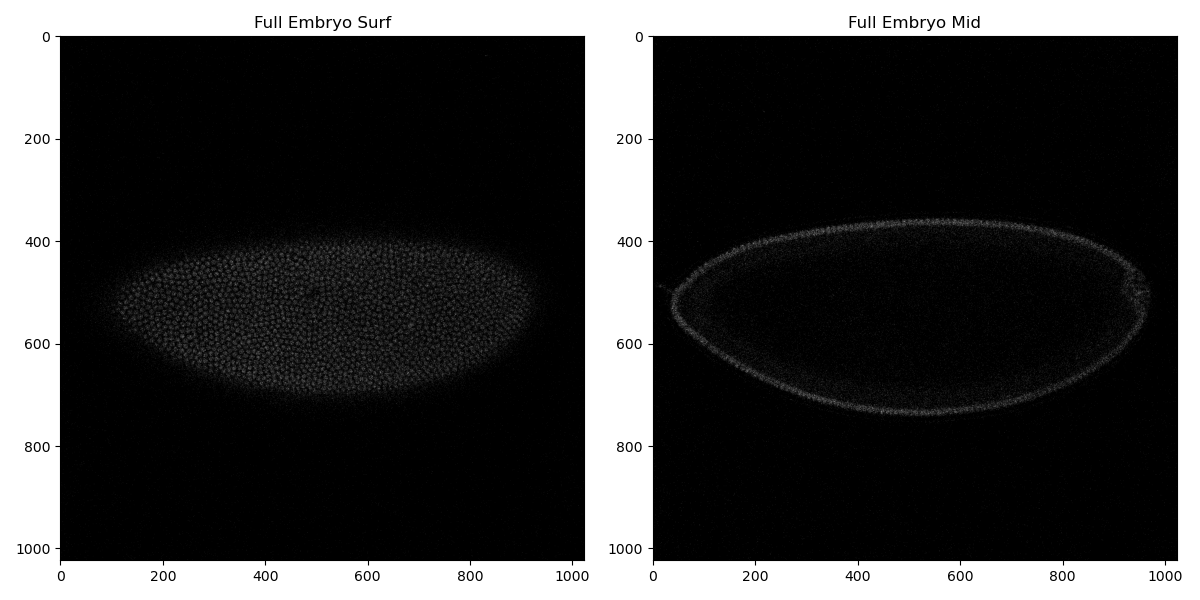

In [16]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_surf[0][0, :, :], cmap='gray')
plt.title('Full Embryo Surf')

plt.subplot(1, 2, 2)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_mid[0][0, :, :], cmap='gray')
plt.title('Full Embryo Mid')

plt.tight_layout()
plt.show()

In [17]:
fullEmbryo = fullEmbryo_pipeline.FullEmbryo(FullEmbryo_dataset, dataset, his_channel=0)

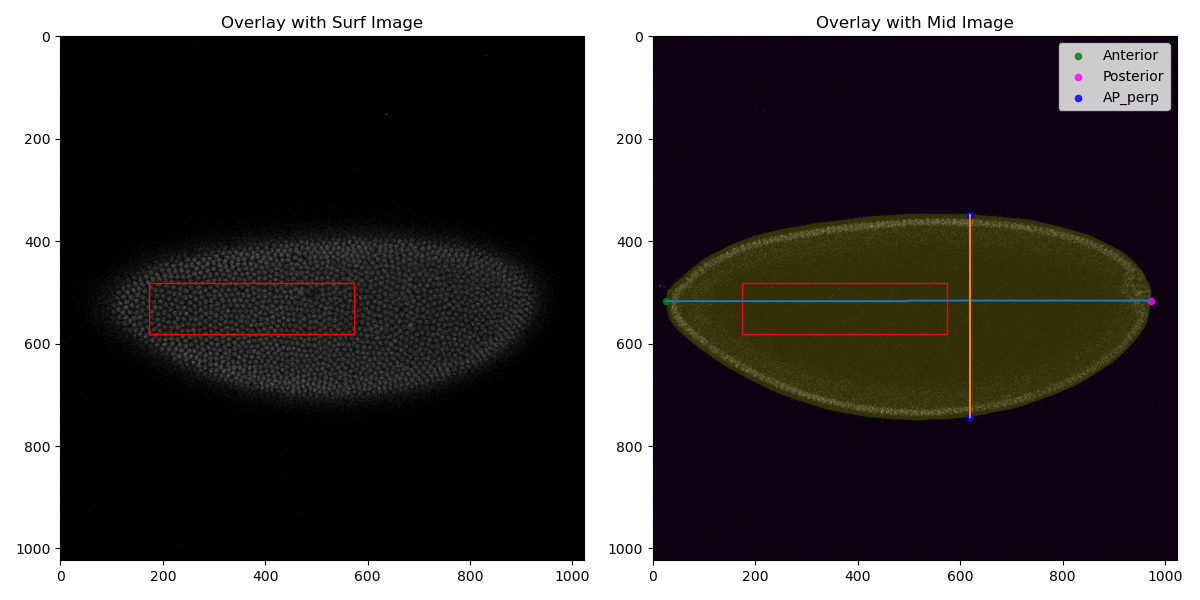

In [18]:
fullEmbryo.find_ap_axis(make_plots=True)

In [19]:
compiled_dataframe = fullEmbryo.xy_to_ap(compiled_dataframe)
compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90
0,1,"[506, 507, 511, 512, 513, 514, 515, 517, 518, ...","[2300.7059993743896, 2304.7430000305176, 2322....","[72.1570804597701, 53.93129347826087, 95.00423...","[25.268212723555116, 24.193128325434877, 23.27...","[425.48808831836254, 423.8314928296911, 425.13...","[221.00383393743027, 221.58308686421765, 221.5...","[0.3313042994154892, 0.33061939863823764, 0.33...","[0.12989276429317786, 0.13046486912365637, 0.1..."
1,2,"[460, 461, 462, 463, 464, 465, 466, 467, 468, ...","[2091.4230003356934, 2095.882999420166, 2100.1...","[57.47963945578232, 38.66103448275862, 90.2138...","[27.24615631798166, 25.318037332850935, 24.569...","[122.58614821001362, 123.76488548423376, 126.0...","[17.180038487563998, 17.208933264743397, 18.12...","[0.20607289824970965, 0.20656023392145914, 0.2...","[-0.07141580498769587, -0.07138726677781301, -..."
2,3,"[527, 528, 529, 530, 531, 532, 533, 534, 535, ...","[2394.573999404907, 2399.2339992523193, 2403.4...","[67.31827607361961, 10.19521568627451, 67.1475...","[26.219966228377146, 26.957198706766793, 25.65...","[588.016012440591, 586.074051884851, 588.18053...","[48.20524698088067, 48.37057827336589, 48.2503...","[0.39849964210332955, 0.3976967603478775, 0.39...","[-0.04077345373697253, -0.0406101626655149, -0..."
3,4,"[572, 573, 574, 576, 577, 578, 580, 581, 582, ...","[2601.6180000305176, 2605.8780002593994, 2610....","[131.19976923076925, 114.73455625, 112.1208231...","[23.632369088123415, 26.48124363284603, 24.361...","[247.29672998614768, 245.9633552657412, 245.16...","[119.09766185700249, 119.2585299587735, 118.06...","[0.25763308598055856, 0.25708181719549955, 0.2...","[0.029244134641654648, 0.029403017599059004, 0..."
4,5,"[486, 489, 490, 491, 492, 493, 494, 495, 496, ...","[2211.6900005340576, 2225.287000656128, 2229.7...","[49.39227659574468, 71.93047777777778, 75.6659...","[23.603968369418688, 23.202337971412053, 23.80...","[473.56080767748307, 471.83975365873124, 471.4...","[127.7748944142374, 128.7753637411546, 128.167...","[0.35117942468222907, 0.3504678742505178, 0.35...","[0.037814288423547136, 0.038802411760013165, 0..."


### Plot Individual Traces as a Check

In [21]:
# Restrict to longer traces
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]

/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/utils/plottable.py:17: UserWarning: Could not determine division time, using absolute time.
  warnings.warn("Could not determine division time, using absolute time.")


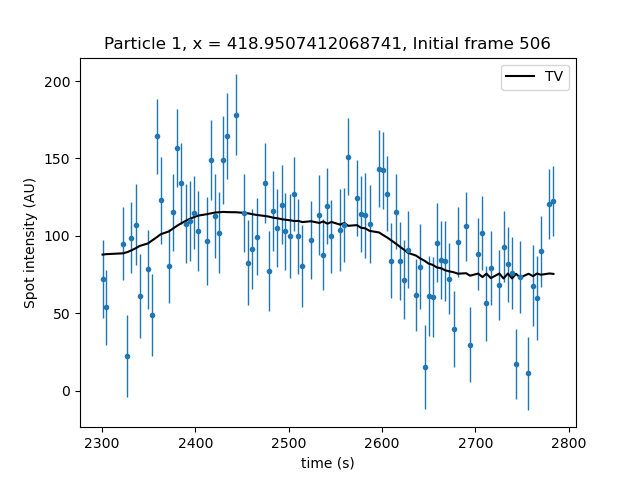

In [22]:
# Copied from Nick's Analysis Notebook

# The part of the code for scrolling between plots is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
#median_filtered_traces = [medfilt(trace[1], kernel_size=15) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]


# plt.close()
# plt.plot(traces[curr_pos][0], traces[curr_pos][1], label="Original")otts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
ax.legend()

plt.show()

## Scheme 1 (Fit & Average): Fitting to Individual MS2 Traces and then Take Their Average for Each Bin

### Define Fit Functions

In [23]:
# fit_all_traces: a function that generates the fit for each trace

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
import emcee

# Version with normalization and regularization
def make_half_cycle(basal, t_on, t_dwell, rate, t_interp):
    half_cycle = np.zeros_like(t_interp)
    half_cycle[t_interp < t_on] = basal
    half_cycle[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] = basal + rate * (t_interp[(t_interp >= t_on) & (t_interp < t_on + t_dwell)] - t_on)
    half_cycle[t_interp >= t_on + t_dwell] = basal + rate * t_dwell
    return half_cycle

def fit_func(params, MS2, timepoints, t_interp):
    return np.interp(timepoints, t_interp, make_half_cycle(*params, t_interp)) - MS2

def initial_guess(MS2, timepoints):
    # Initial guess for the parameters
    basal0 = MS2[0]
    t_on0 = timepoints[0]
    t_dwell0 = (2/3)*(timepoints[-1]-timepoints[0])
    rate0 = 1
    # print(np.max(mean_dy_dx))
    return [basal0, t_on0, t_dwell0, rate0]


def fit_half_cycle(MS2, timepoints, t_interp, std_errors, max_nfev=3000):
    # Initial guess
    x0 = initial_guess(MS2, timepoints)
    
    # Parameter bounds
    lb = [np.min(MS2), 0, 0, 0]  # Ensure t_dwell is non-negative
    ub = [np.max(MS2), np.max(timepoints), np.max(timepoints), 1e7]

    # Scaling factors to normalize parameters
    scale_factors = np.array([np.max(MS2), np.max(timepoints), np.max(timepoints), 100])

    # Scaled bounds
    lb_scaled = np.array(lb) / scale_factors
    ub_scaled = np.array(ub) / scale_factors
    x0_scaled = np.array(x0) / scale_factors

    # Scaled fit function
    def fit_func_scaled(params, MS2, timepoints, t_interp):
        params_unscaled = params * scale_factors
        return fit_func(params_unscaled, MS2, timepoints, t_interp)

    # Negative log-likelihood function
    def negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors, reg=1e-3):
        residuals = fit_func_scaled(params, MS2, timepoints, t_interp) / std_errors
        regularization = reg * np.sum(params[:]**2)
        nll = 0.5 * np.sum(residuals**2) + regularization
        return nll

    # Initial parameter estimation using least_squares
    res = least_squares(negative_log_likelihood, 
                        x0_scaled, bounds=(lb_scaled, ub_scaled), 
                        args=(MS2, timepoints, t_interp, std_errors), max_nfev=max_nfev)
    

    # Define log-probability function for MCMC
    def log_prob(params, MS2, timepoints, t_interp, std_errors, scale_factors, lb_scaled, ub_scaled):
        if np.any(params < lb_scaled) or np.any(params > ub_scaled):
            return -np.inf
        nll = negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors)
        return -nll  # Convert to log-probability

    # MCMC parameters
    nwalkers = 10
    ndim = len(x0_scaled)
    nsteps = 1000
    initial_pos = res.x + 1e-4 * np.random.randn(nwalkers, ndim)
    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(MS2, timepoints,
                                                                    t_interp, std_errors,
                                                                    scale_factors, lb_scaled, ub_scaled))
    # Run MCMC until the acceptance fraction is at least 0.5
    sampler.run_mcmc(initial_pos, nsteps, 
                     progress=False, tune=True)

    # Flatten the chain and discard burn-in steps
    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

    # Extract and rescale fit parameters
    basal, t_on, t_dwell, rate = np.median(flat_samples, axis=0) * scale_factors

    # Calculate confidence intervals
    CI = np.percentile(flat_samples, [5, 95], axis=0).T * scale_factors[:, np.newaxis]

    return basal, t_on, t_dwell, rate, CI

def first_derivative(x, y):
    """
    Compute the first discrete derivative of y with respect to x.
    Parameters:
    x (numpy.ndarray): Independent variable data points.
    y (numpy.ndarray): Dependent variable data points.
    Returns:
    numpy.ndarray: Discrete first derivative of y with respect to x.
    """
    dx = np.diff(x)
    dy = np.diff(y)
    dydx = dy / dx

    # Use central differences for the interior points and forward/backward differences for the endpoints
    dydx_central = np.zeros_like(y)
    dydx_central[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dydx_central[0] = dydx[0]
    dydx_central[-1] = dydx[-1]

    return dydx_central

def mean_sign_intervals(function):
    """
    Compute the mean of function over intervals where the function has a constant sign.
    Parameters:
    derivative (numpy.ndarray): Array representing the function.
    Returns:
    numpy.ndarray: Array with mean values of the function over intervals with constant sign.
    """
    # Identify where the sign changes
    sign_changes = np.diff(np.sign(function))
    # Get indices where the sign changes
    change_indices = np.where(sign_changes != 0)[0] + 1

    # Initialize the list to hold mean values
    mean_values = []
    start_index = 0

    for end_index in change_indices:
        # Calculate the mean of the current interval
        interval_mean = np.mean(function[start_index:end_index])
        # Append the mean value to the list
        mean_values.extend([interval_mean] * (end_index - start_index))
        # Update the start index
        start_index = end_index

    # Handle the last interval
    interval_mean = np.mean(function[start_index:])
    mean_values.extend([interval_mean] * (len(function) - start_index))

    return np.array(mean_values), change_indices

# Function to generate fits for all traces
def fit_all_traces(traces, tv_denoised_traces):
    """
    Fit half-cycles to all traces in the dataset.
    Parameters:
    traces (list): List of traces to fit.
    tv_denoised_traces (list): List of TV denoised traces.
    Returns:
    list: List of tuples with fit parameters for each trace.
    """
    # Initialize the list to hold fit results
    fit_results = []

    # Create new dataframe to store fit results
    dataframe = pd.DataFrame(columns=['particle', 'fit_results'])
    
    for i in range(len(traces)):
        # Compute the first derivative of TV denoised with respect to time
        dy_dx = first_derivative(traces[i][0], tv_denoised_traces[i])

        # Compute the mean of the first derivative over intervals with constant sign
        mean_dy_dx, change_indices = mean_sign_intervals(dy_dx)

        # Keep datapoints from before first sign change
        try:
            timepoints = traces[i][0][:change_indices[0]]
            MS2 = traces[i][1][:change_indices[0]]
            MS2_std = traces[i][2][:change_indices[0]]

            # Interpolate the timepoints
            t_interp = np.linspace(min(timepoints), max(timepoints), 1000)
        except:
            print(f"Failed to find derivative sign change for trace {traces[i][3]}")
            fit_results.append([None, None, None, None, None])
            dataframe.loc[i] = [traces[i][3], [None, None, None, None, None]]
            continue


        # Compute the fit values
        try:
            basal, t_on, t_dwell, rate, CI = fit_half_cycle(MS2, timepoints, t_interp, MS2_std)
            fit_result = [timepoints, t_interp, MS2, make_half_cycle(basal, t_on, t_dwell, rate, t_interp),
                                [basal, t_on, t_dwell, rate, CI]]
            
            fit_results.append(fit_result)
            dataframe.loc[i] = [traces[i][3], fit_result]
        except:
            print(f"Failed to fit trace {traces[i][3]}")
            fit_results.append([timepoints,t_interp, MS2, None, None])
            dataframe.loc[i] = [traces[i][3], [timepoints,t_interp, MS2, None, None]]
            continue

    return fit_results, dataframe

In [24]:
def fit_linear(MS2, timepoints, t_interp, std_errors, max_nfev=3000):

    # Scaling factors to normalize parameters
    ceiling = lambda x: -(-x//1)
    slope = lambda y, x: (np.max(y) - np.min(y))/(np.max(x) - np.min(x))
    
    estimated_slope = slope(MS2, timepoints)
    order_of_mag_slope = ceiling(np.log10(estimated_slope))
    slope_scale_factor = 10**order_of_mag_slope
    
    scale_factors = np.array([slope_scale_factor, np.max(timepoints)])

    def initial_guess(MS2, timepoints):
        # initial guess for the parameters
        # dy = np.max(MS2)-np.min(MS2)
        # dx = np.max(timepoints) - np.min(timepoints)
        slope0 = slope(MS2, timepoints)

        intercept0 = np.min(MS2) - np.min(timepoints)

        return [slope0, intercept0]
        
    #x0 = [(np.max(MS2)-np.min(MS2))/(np.max(timepoints) - np.min(timepoints)), np.min(MS2)]
    x0 = initial_guess(MS2, timepoints)
    x0_scaled = x0/scale_factors

    f = lambda k, b, x: k*x + b
    
    # Fit function
    def fit_func(params, MS2, timepoints, t_interp):
        return np.interp(timepoints, t_interp, f(*params, t_interp)) - MS2

    # Scaled fit function
    def fit_func_scaled(params, MS2, timepoints, t_interp):
        params_unscaled = params * scale_factors
        return fit_func(params_unscaled, MS2, timepoints, t_interp)

    # Negative log-likelihood function
    def negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors, reg=1e-3):
        residuals = fit_func_scaled(params, MS2, timepoints, t_interp) / std_errors
        regularization = reg * np.sum(params[:]**2)
        nll = 0.5 * np.sum(residuals**2) + regularization
        return nll

    # Initial parameter estimation using least_squares
    res = least_squares(negative_log_likelihood, x0_scaled,
                        args=(MS2, timepoints, t_interp, std_errors), max_nfev=max_nfev)
    

    # Define log-probability function for MCMC
    def log_prob(params, MS2, timepoints, t_interp, std_errors):
        nll = negative_log_likelihood(params, MS2, timepoints, t_interp, std_errors)
        return -nll  # Convert to log-probability

    # MCMC parameters
    nwalkers = 10
    ndim = len(x0)
    nsteps = 1000
    initial_pos = res.x + 1e-4 * np.random.randn(nwalkers, ndim)
    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(MS2, timepoints,
                                                                    t_interp, std_errors))
    # Run MCMC until the acceptance fraction is at least 0.5
    sampler.run_mcmc(initial_pos, nsteps, 
                     progress=False, tune=True)

    # Flatten the chain and discard burn-in steps
    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

    # Extract and rescale fit parameters
    slope, intercept = np.median(flat_samples, axis=0) * scale_factors

    # Calculate confidence intervals
    CI = np.percentile(flat_samples, [5, 95], axis=0).T * scale_factors

    return slope, intercept, CI

### Perform Fitting on Ordered Spots

In [25]:
# Restrict to longer traces
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]
# Restrict to traces starting at frame nc14_start_frame and above
traces_compiled_dataframe = traces_compiled_dataframe[
    traces_compiled_dataframe["frame"].apply(lambda x: x[0] >= nc14_start_frame)
]

# Order the traces based on the mean x position
traces_compiled_dataframe = traces_compiled_dataframe.sort_values(
    by="x", key=lambda x: x.apply(np.mean)
)

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)


# Generate TV denoised traces
tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]

# Generate fits for all traces
fit_results, dataframe = fit_all_traces(traces, tv_denoised_traces)

print(f"Number of traces: {len(traces)}")

# Show number of traces with valid fits
print(f"Number of traces with valid fits: {sum([result[4] is not None for result in fit_results])}")

# Show number of traces with invalid fits
print(f"Number of traces with invalid fits: {sum([result[4] is None for result in fit_results])}")

traces_compiled_dataframe_fits = pd.merge(traces_compiled_dataframe, dataframe, on='particle', how='inner')

# Add columns: the approval status, denoised trace, and fitted rate of the particle
length = traces_compiled_dataframe_fits.index.max()
status = [0 for _ in range(length+1)]
modified_fit_results = [None for _ in range(length+1)]
traces_compiled_dataframe_fits['modified_fit_results'] = modified_fit_results
traces_compiled_dataframe_fits['tv_denoised_trace'] = tv_denoised_traces
traces_compiled_dataframe_fits['approval_status'] = status

/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/utils/plottable.py:17: UserWarning: Could not determine division time, using absolute time.
  warnings.warn("Could not determine division time, using absolute time.")
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Failed to find derivative sign change for trace 301


/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encoun

Failed to fit trace 225
Failed to fit trace 61


/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Failed to fit trace 183


/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Failed to fit trace 130
Number of traces: 137
Number of traces with valid fits: 132
Number of traces with invalid fits: 5


In [26]:
traces_compiled_dataframe_fits.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90,fit_results,modified_fit_results,tv_denoised_trace,approval_status
0,258,"[477, 478, 480, 481, 482, 483, 484, 487, 488, ...","[2171.107000350952, 2175.7789993286133, 2184.6...","[128.7251724137931, 135.9469775280899, 140.735...","[24.313749617281225, 27.69677638823855, 26.526...","[4.603282016220054, 4.942160779400182, 4.67300...","[127.07031562237795, 127.83368252652197, 126.0...","[0.15729420887677814, 0.15743431449090262, 0.1...","[0.037118404274094255, 0.037872351078835215, 0...","[[2171.107000350952, 2175.7789993286133, 2184....",None,"[166.17713895477272, 166.3681431518292, 166.75...",0
1,175,"[481, 483, 485, 486, 487, 488, 489, 491, 492, ...","[2189.798999786377, 2198.718999862671, 2207.22...","[61.20902890173411, 69.0975608108108, 58.19808...","[21.98403302021128, 22.67749098437827, 27.6577...","[10.156944029488237, 11.327991746313508, 11.02...","[209.99416029420047, 211.55650260195583, 210.4...","[0.1595903079881736, 0.16007446449888316, 0.15...","[0.11901895221212938, 0.12056201490511394, 0.1...","[[2189.798999786377, 2198.718999862671, 2207.2...",None,"[110.3288781619955, 110.80643754627314, 111.79...",0
2,276,"[485, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2207.8589992523193, 2216.566999435425, 2221.2...","[67.97339306358381, 75.30527624309391, 87.8247...","[23.011813316636232, 24.525760823825948, 27.04...","[12.268911710174077, 11.675486979035856, 11.41...","[58.323222547333174, 57.757125096299006, 58.96...","[0.16046347727779428, 0.16021813249545222, 0.1...","[-0.030780336001107352, -0.03133944769701967, ...","[[2207.8589992523193, 2216.566999435425, 2221....",None,"[108.82564520239234, 109.10907207684687, 109.6...",0
3,313,"[466, 467, 468, 469, 470, 471, 472, 473, 474, ...","[2118.413999557495, 2123.2940006256104, 2127.5...","[85.72741875000001, 49.311, 112.05398136645962...","[25.59952213087846, 28.315972153539068, 25.320...","[5.123111904292513, 5.031120722834717, 7.02653...","[22.26367942794014, 22.20860118785958, 22.2815...","[0.15750912669878972, 0.15747109397920817, 0.1...","[-0.06639489718747522, -0.06644929575112024, -...","[[2118.413999557495, 2123.2940006256104, 2127....",None,"[110.80487559634494, 111.30480424823801, 112.3...",0
4,108,"[461, 463, 464, 465, 466, 467, 468, 469, 470, ...","[2095.673999786377, 2104.183000564575, 2108.64...","[66.07425, 78.0525621301775, 55.76315, 73.5683...","[24.982523501057464, 23.666196080514528, 24.98...","[6.622973244232735, 8.61024155058676, 9.265356...","[142.98810338320803, 142.3111077702882, 142.61...","[0.15812922750464098, 0.15895084124012263, 0.1...","[0.05283976336848658, 0.05217112201605997, 0.0...","[[2095.673999786377, 2104.183000564575, 2108.6...",None,"[85.6171155974248, 85.96931952744035, 85.97253...",0


### Checking the Fits

In [27]:
# check_particle_fit: a function that checks the fits

### Josh's Fit checking function, updated on 9.4.2024. Added the function to select a certain particle to look at
def check_particle_fit(binned_particles_fitted, show_denoised_plot=False):
    '''
    Check the fit of each particle. 

    ARGUMENT
        bin_average_fit_dataframe: a pandas dataframe containing the bin average fit data.
        show_denoised_plot: show the denoised trace of the data points, default is False.
        show_fit: show the half cycle fit for the data points, default is True.
        show_std_dev: show the standard deviation for each data point.
        show_std_err: show the standard error for each data point.

    KEY INPUTS
        left (<-): move to previous bin
        right (->): move to next bin
        a: accept fit for this bin (plot turns green)
        r: reject fit for this bin (plot turns red)
        c: clear approval status (plot returns white)
        i: move to the particle with the given particle index
        j: jump to the n-th particle in the list (with n given)
        f: redo the fit based on data within a certain x range,
           which is determined by clicking twice on the plot
           (plot turns yellow)
    '''

    fig, ax = plt.subplots()
    
    particle_index = 0
    particle_num = binned_particles_fitted.index.max()
    x = None
    y = None
    y_denoised = None
    y_err = None

    # move to the first unchecked particle--------------------------------------
    first_flag = False
    while not first_flag:
        particle_data = binned_particles_fitted[particle_index:particle_index+1]
        status = particle_data['approval_status'].values[0]
        if status == 0:
            first_flag = True
            if not particle_index == 0:
                print(f'Moved to particle {particle_index+1} out of {particle_num}, the first unchecked particle')
        else:
            if particle_index < particle_num:
                particle_index += 1
            elif particle_index == particle_num:
                warn('No particle has been left unchecked')
                particle_index = 0
                break
    #---------------------------------------------------------------------------
    
    def update_plot(particle_index):
        nonlocal x, y, y_denoised, y_err
        ax.clear()
            
        try:
            particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
            
            x = particle_data['t_s'].values[0]
            y = particle_data['intensity_from_neighborhood'].values[0]
            y_denoised = particle_data['tv_denoised_trace'].values[0]
            y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]
    
            # plot the particle trace with error bar along with the denoised trace
            ax.errorbar(x/60, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
            if show_denoised_plot:
                ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the fit
            
            try:
                # plot the modified linear fit
                modified = (particle_data['approval_status'].values == 2)
                if modified:
                    fit_result = particle_data['modified_fit_results'].values[0]
                    timepoints, t_interp, MS2, fit, [intercept, _, _, rate, CI] = fit_result
                    ax.errorbar(timepoints/60, MS2, fmt=".", elinewidth=1, label='Selected data for modified fit')

                # plot the original half cycle fit
                else:
                    fit_result = particle_data['fit_results'].values[0]
                    timepoints, t_interp, MS2, fit, [basal, t_on, t_dwell, rate, CI] = fit_result

                if modified:
                    ax.plot(t_interp/60, fit, label=f'Modified fit (slope = {round(rate*60,2)} AU/min)', linewidth=3)
                else:
                    ax.plot(t_interp/60, fit, label=f'Fit (slope = {round(rate*60,2)} AU/min)', linewidth=3)
    
                # ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
            except:
                pass
    
            particle = particle_data['particle'].values[0]
            # bin = particle_data['bin'].values[0]
            mean_x = (particle_data.loc[particle_data["particle"] == particle, "x"]
            .values[0]
            .mean()
            )
            initial_frame = (compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"].
            values[0][0]
            )
            status = particle_data['approval_status'].values[0]
    
            if status == 1:
                ax.set_facecolor((0.7, 1, 0.7)) # approve
            elif status == -1:
                ax.set_facecolor((1, 0.7, 0.7)) # reject color
            elif status == 0:
                ax.set_facecolor((1, 1, 1))
            elif status == 2:
                ax.set_facecolor((1, 1, 0.7))
            
            ax.set_title(f'Particle #{particle} ({particle_index+1}/{particle_num+1}), x = {np.round(mean_x, 2)}, Initial frame {initial_frame}')
            ax.set_xlabel("Time (min)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()

        except Exception as e:
            particle = particle_data['particle'].values[0]
            print(f"Error processing particle {particle}: {e}")

        fig.canvas.draw()

    def on_key(event):
        nonlocal particle_index
        nonlocal x, y, y_denoised, y_err
        if event.key == 'left':
            # move to the previous particle
            particle_index = max(0, particle_index - 1)
        elif event.key == 'right':
            # move to the next particle
            particle_index = min(len(binned_particles_fitted) - 1, particle_index + 1)
        elif event.key == 'a':
            # accept the fit for this particle
            binned_particles_fitted.at[particle_index, 'approval_status'] = 1
        elif event.key == 'r':
            # reject the fit for this particle
            binned_particles_fitted.at[particle_index, 'approval_status'] = -1
        elif event.key == 'c':
            # clear the approval status for this particle
            binned_particles_fitted.at[particle_index, 'approval_status'] = 0
            binned_particles_fitted.at[particle_index, 'modified_fit_results'] = None
        elif event.key == 'i':
            # Move to the particle with the particle index given
            # Create a Tkinter root window and hide it
            root = tk.Tk()
            root.withdraw()

            index_array = np.sort(binned_particles_fitted['particle'].values)
            # Ask for input
            input_index = simpledialog.askinteger("Input", f"Choose particle index from {index_array}:", minvalue=0)#, maxvalue=particle_num)

            # Update the particle index if input is valid
            if input_index is not None:
                particle_index = binned_particles_fitted[binned_particles_fitted['particle'] == input_index].index.values[0]
            
            # Destroy the Tkinter root window
            root.destroy()

        elif event.key == 'j':
            # Jump to the nth particle in the list
            # Create a Tkinter root window and hide it
            root = tk.Tk()
            root.withdraw()

            # Ask for input
            input_index = simpledialog.askinteger("Input", f"Jump to particle __ out of {particle_num+1}:", minvalue=1, maxvalue=particle_num+1)

            # Update the particle index if input is valid
            if input_index is not None:
                particle_index = input_index-1

            # Destroy the Tkinter root window
            root.destroy()

        elif event.key == 'f':
            # Fit based on a chosen range
            def get_two_numbers():
                # Create a window
                root = tk.Tk()
                root.withdraw()  # Hide the root window
            
                # Ask for the first number
                num1 = simpledialog.askfloat("Input the range to fit a line", "Enter the left bound of the range:")
                
                # Ask for the second number
                num2 = simpledialog.askfloat("Input the range to fit a line", "Enter the right bound of the range:")
            
                return num1, num2
            
            x_min, x_max = get_two_numbers()
            
            # Select points within the range of x_min and x_max
            mask = (x >= x_min*60) & (x <= x_max*60)
            new_x = x[mask]
            new_y = y[mask]
            new_yerr = y_err[mask]

            x_interp = np.linspace(min(new_x), max(new_x), 1000)

            # The linear regime------------------------------------------
            f = lambda k, b, x: k*x + b
            try:
                
                slope, intercept, CI = fit_linear(new_y, new_x, x_interp, new_yerr)

                slope_conf_interval = CI[0]
                intercept_conf_interval = CI[1]

                particle_fit_result_modified = [new_x, x_interp, new_y, f(slope, intercept, x_interp), 
                                                       [intercept, np.nan, np.nan, slope, 
                                                        np.array([intercept_conf_interval, [np.nan, np.nan], 
                                                                  [np.nan, np.nan], slope_conf_interval])]]

                binned_particles_fitted.at[particle_index, 'modified_fit_results'] = particle_fit_result_modified

                binned_particles_fitted.at[particle_index, 'approval_status'] = 2
                
            except:      
                pass

        update_plot(particle_index)
        
    update_plot(particle_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

#### Test cells (can be deleted later)

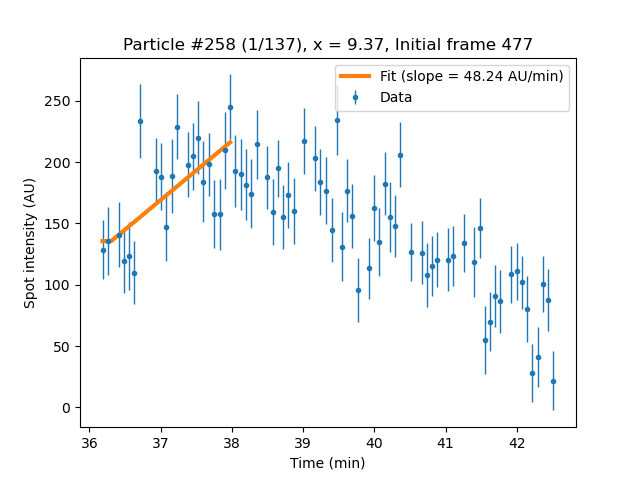

In [298]:
check_particle_fit(traces_compiled_dataframe_fits)

In [206]:
traces_compiled_dataframe_fits.at[0, 'fit_results'][-1]

[128.44144254273715,
 2181.5757800300726,
 618.2671286148483,
 0.8674436888513117,
 array([[1.12377870e+02, 1.52976185e+02],
        [2.13159433e+03, 2.19726713e+03],
        [1.75895854e+01, 2.04380053e+03],
        [4.61024145e-01, 3.73766982e+00]])]

In [108]:
new_x, x_interp, new_y, fit, CI = traces_compiled_dataframe_fits.at[1, 'modified_fit_results']

In [290]:
particle_index = 0
x_min = 36
x_max = 38
binned_particles_fitted = traces_compiled_dataframe_fits

particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
            
x = particle_data['t_s'].values[0]
y = particle_data['intensity_from_neighborhood'].values[0]
y_denoised = particle_data['tv_denoised_trace'].values[0]
y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]

mask = (x >= x_min*60) & (x <= x_max*60)
new_x = x[mask]
# first_x = new_x[0]
# new_x = new_x - first_x
new_y = y[mask]
new_yerr = y_err[mask]
#new_yerr = np.ones(new_y.shape[0])*0.1

x_interp = np.linspace(min(new_x), max(new_x), 1000)


slope, intercept, CI = fit_linear(new_y, new_x, x_interp, new_yerr)

slope_conf_interval = CI[0]
intercept_conf_interval = CI[1]

particle_fit_result_modified = [new_x, x_interp, new_y, f(slope, intercept, x_interp), 
                                       [intercept, np.nan, np.nan, slope, 
                                        np.array([intercept_conf_interval, [np.nan, np.nan], 
                                                  [np.nan, np.nan], slope_conf_interval])]]


# basal, t_on, t_dwell, rate, CI = fit_half_cycle(new_y, new_x, x_interp, new_yerr)
            
# particle_fit_result_modified = [new_x, x_interp, new_y, make_half_cycle(basal, t_on, t_dwell, rate, x_interp),
#                                         [basal, t_on, t_dwell, rate, CI]]

binned_particles_fitted.at[particle_index, 'modified_fit_results'] = particle_fit_result_modified

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [215]:
def initial_guess(MS2, timepoints):
    # initial guess for the parameters
    dy = np.max(MS2)-np.min(MS2)
    dx = np.max(timepoints) - np.min(timepoints)
    slope0 = dy/dx

    intercept0 = np.min(MS2) - np.min(timepoints)

    return [slope0, intercept0]


initial_guess(y, x)

[0.5887197597321546, -2149.4047458054974]

In [289]:
particle_fit_result_modified[-1]

[-1574.9281268709829,
 nan,
 nan,
 0.7828913272550232,
 array([[-1.00198823e+02, -9.98297374e+02],
        [            nan,             nan],
        [            nan,             nan],
        [ 5.25417459e-01,  2.51451058e+01]])]

/tmp/ipykernel_2415153/3125183153.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


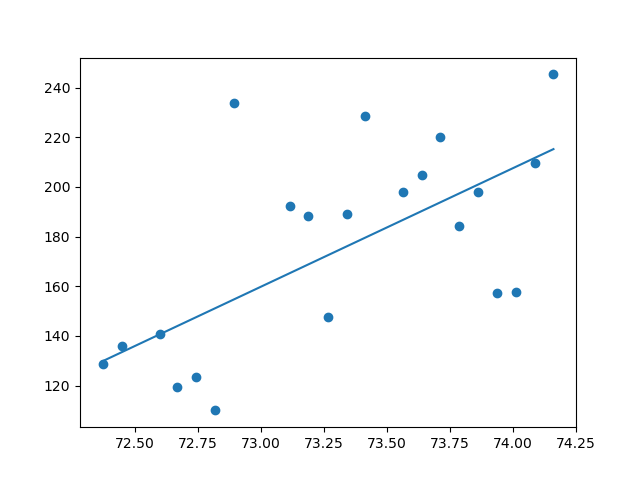

In [242]:
plt.figure()
plt.scatter((new_x + first_x)/60, new_y)
plt.plot((x_interp + first_x)/60, slope*x_interp + intercept)

# plt.scatter(new_x/60, new_y)
# plt.plot(x_interp/60, particle_fit_result_modified[3])

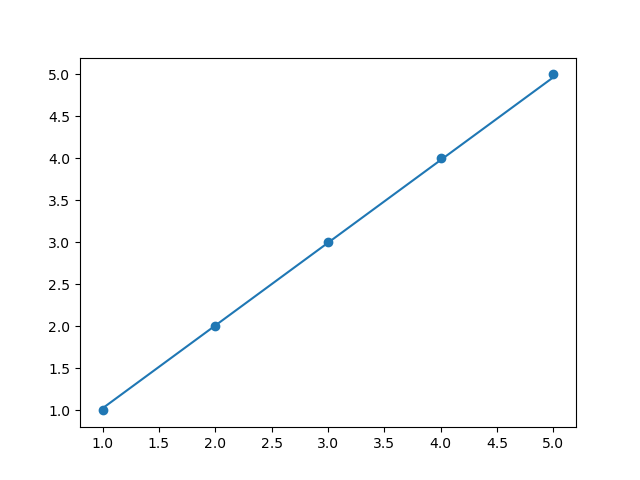

In [119]:
y = np.array([1, 2, 3, 4, 5])
yerr = np.array([0.5]*5)
x = np.array([1, 2, 3, 4, 5])
x_interp = np.linspace(min(x), max(x), 1000)

k, b, CI = fit_linear(y, x, x_interp, yerr)

plt.figure()
plt.scatter(x, y)
plt.plot(x_interp, k*x_interp + b)

In [115]:
particle_fit_result_modified[-1]

[-2.76578491577321,
 nan,
 nan,
 0.07927457503999999,
 array([[-36.63408025,  34.25711389],
        [         nan,          nan],
        [         nan,          nan],
        [  0.06320684,   0.09630986]])]

In [125]:
# check_particle_fit: manual linear fit to be added

### Josh's Fit checking function, updated on 9.4.2024. Added the function to select a certain particle to look at
def check_particle_fit(binned_particles_fitted, show_denoised_plot=False):
    '''
    Check the fit of each particle. All particles are approved by default.
    '''

    fig, ax = plt.subplots()
    
    particle_index = 0
    particle_num = binned_particles_fitted.index.max()

    # move to the first unchecked particle--------------------------------------
    # first_flag = False
    # while not first_flag:
    #     particle_data = binned_particles_fitted[particle_index:particle_index+1]
    #     status = particle_data['approval_status'].values[0]
    #     if status == 0:
    #         first_flag = True
    #     else:
    #         if particle_index < particle_num:
    #             particle_index += 1
    #         elif particle_index == particle_num:
    #             warn('No particle has been left unchecked')
    #             break
    #---------------------------------------------------------------------------
    
    def update_plot(particle_index):
        ax.clear()
            
        try:
            particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
            
            x = particle_data['t_s'].values[0]
            y = particle_data['intensity_from_neighborhood'].values[0]
            y_denoised = particle_data['tv_denoised_trace'].values[0]
            y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]
    
            # plot the particle trace with error bar along with the denoised trace
            ax.errorbar(x/60, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
            if show_denoised_plot:
                ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the fit
            
            try:
                # plot the modified linear fit
                if particle_data['approval_status'].values == 2:
                    fit_result = particle_data['modified_fit_results'].values[0]
                    timepoints, t_interp, MS2, fit, [rate, intercept, CI] = fit_result

                # plot the original half cycle fit
                else:
                    fit_result = particle_data['fit_results'].values[0]
                    timepoints, t_interp, MS2, fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
                ax.plot(t_interp/60, fit, label=f'Fit (slope = {round(rate*60,2)} AU/min)', linewidth=3)
    
                # ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
            except:
                pass
    
            particle = particle_data['particle'].values[0]
            # bin = particle_data['bin'].values[0]
            mean_x = (particle_data.loc[particle_data["particle"] == particle, "x"]
            .values[0]
            .mean()
            )
            initial_frame = (compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"].
            values[0][0]
            )
            status = particle_data['approval_status'].values[0]
    
            if status == 1:
                ax.set_facecolor((0.7, 1, 0.7)) # approve
            elif status == -1:
                ax.set_facecolor((1, 0.7, 0.7)) # reject color
            elif status == 0:
                ax.set_facecolor((1, 1, 1))
            elif status == 2:
                ax.set_facecolor((1, 1, 0.7))
            
            ax.set_title(f'Particle #{particle} ({particle_index+1}/{particle_num+1}), x = {np.round(mean_x, 2)}, Initial frame {initial_frame}')
            ax.set_xlabel("Time (min)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()

        except Exception as e:
            particle = particle_data['particle'].values[0]
            print(f"Error processing particle {particle}: {e}")

        fig.canvas.draw()

    def on_key(event):
        nonlocal particle_index
        nonlocal x, y, y_denoised, y_err
        nonlocal particle_fit_result_modified
        if event.key == 'left':
            # move to the previous particle
            particle_index = max(0, particle_index - 1)
        elif event.key == 'right':
            # move to the next particle
            particle_index = min(len(binned_particles_fitted) - 1, particle_index + 1)
        elif event.key == 'a':
            # accept the fit for this particle
            binned_particles_fitted.at[particle_index, 'approval_status'] = 1
        elif event.key == 'r':
            # reject the fit for this particle
            binned_particles_fitted.at[particle_index, 'approval_status'] = -1
        elif event.key == 'c':
            # clear the approval status for this particle
            binned_particles_fitted.at[particle_index, 'approval_status'] = 0            
        elif event.key == 'i':
            # Move to the particle with the particle index given
            # Create a Tkinter root window and hide it
            root = tk.Tk()
            root.withdraw()

            index_array = np.sort(binned_particles_fitted['particle'].values)
            # Ask for input
            input_index = simpledialog.askinteger("Input", f"Choose particle index from {index_array}:", minvalue=0)#, maxvalue=particle_num)

            # Update the particle index if input is valid
            if input_index is not None:
                particle_index = binned_particles_fitted[binned_particles_fitted['particle'] == input_index].index.values[0]
            
            # Destroy the Tkinter root window
            root.destroy()

        elif event.key == 'j':
            # Jump to the nth particle in the list
            # Create a Tkinter root window and hide it
            root = tk.Tk()
            root.withdraw()

            # Ask for input
            input_index = simpledialog.askinteger("Input", f"Jump to particle __ out of {particle_num+1}:", minvalue=1, maxvalue=particle_num+1)

            # Update the particle index if input is valid
            if input_index is not None:
                particle_index = input_index-1

            # Destroy the Tkinter root window
            root.destroy()

        elif event.key == 'f':
            # Choose the datapoints between two clicks and fit a line to them
            clicks = []
            
            def onclick(event):
                nonlocal x, y, y_denoised, y_err
                nonlocal particle_fit_result_modified
                # Capture the click
                clicks.append(event.xdata)
                if len(clicks) == 2:
                    # Get the x-coordinates of the two clicks
                    x_min = min(clicks[0], clicks[1])
                    x_max = max(clicks[0], clicks[1])
                    
                    # Select points within the range of x_min and x_max
                    mask = (x >= x_min) & (x <= x_max)
                    new_x = x[mask]
                    new_y = y[mask]
                    new_yerr = y_stderr[mask]

                    x_interp = np.linspace(min(new_x), max(new_x), 1000)

                    # The linear regime------------------------------------------
                    f = lambda k, b, x: k*x + b
                    try:
                        rate, intercept, CI = fit_linear(new_y, new_x, x_interp, new_yerr)
        
                        particle_fit_result_modified = [new_x, x_interp, new_y, f(rate, intercept, x_interp),
                                    [rate, intercept, CI]]
                        
                    except:
                        pass
                    #----------------------------------------------------------------------
        
                    # Disconnect after two clicks
                    fig.canvas.mpl_disconnect(cid)
                    update_plot(bin_index)

            # Connect the click event to the handler
            cid = fig.canvas.mpl_connect('button_press_event', onclick)            

        update_plot(particle_index)
        
    update_plot(particle_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

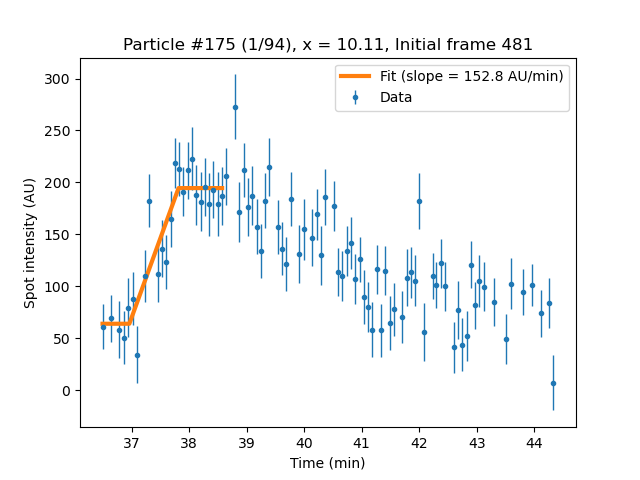

In [138]:
binned_particles_fitted = traces_compiled_dataframe_fits_checked_temp
show_denoised_plot = False

fig, ax = plt.subplots()

particle_index = 0
particle_num = binned_particles_fitted.index.max()
x = None
y = None
y_denoised = None
y_err = None
particle_fit_result_modified = None

# move to the first unchecked particle--------------------------------------
# first_flag = False
# while not first_flag:
#     particle_data = binned_particles_fitted[particle_index:particle_index+1]
#     status = particle_data['approval_status'].values[0]
#     if status == 0:
#         first_flag = True
#     else:
#         if particle_index < particle_num:
#             particle_index += 1
#         elif particle_index == particle_num:
#             warn('No particle has been left unchecked')
#             break
#---------------------------------------------------------------------------

def update_plot(particle_index):
    global x, y, y_denoised, y_err
    global particle_fit_result_modified
    ax.clear()
    
    if particle_fit_result_modified is not None:
        
        binned_particles_fitted.at[particle_index, 'modified_fit_results'] = partice_fit_result_modified

        binned_particles_fitted.at[particle_index, 'approval_status'] = 2

        particle_fit_result_modified = None
        
    try:
        particle_data = binned_particles_fitted[particle_index:particle_index+1] # select the particle
        
        x = particle_data['t_s'].values[0]
        y = particle_data['intensity_from_neighborhood'].values[0]
        y_denoised = particle_data['tv_denoised_trace'].values[0]
        y_err = particle_data['intensity_std_error_from_neighborhood'].values[0]

        # plot the particle trace with error bar along with the denoised trace
        ax.errorbar(x/60, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
        if show_denoised_plot:
            ax.plot(x, y_denoised, color='k', label='TV denoised')

        # plot the fit
        
        try:
            # plot the modified linear fit
            if particle_data['approval_status'].values == 2:
                fit_result = particle_data['modified_fit_results'].values[0]
                timepoints, t_interp, MS2, fit, [rate, intercept, CI] = fit_result

            # plot the original half cycle fit
            else:
                fit_result = particle_data['fit_results'].values[0]
                timepoints, t_interp, MS2, fit, [basal, t_on, t_dwell, rate, CI] = fit_result

            ax.plot(t_interp/60, fit, label=f'Fit (slope = {round(rate*60,2)} AU/min)', linewidth=3)

            # ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
        except:
            pass

        particle = particle_data['particle'].values[0]
        # bin = particle_data['bin'].values[0]
        mean_x = (particle_data.loc[particle_data["particle"] == particle, "x"]
        .values[0]
        .mean()
        )
        initial_frame = (compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"].
        values[0][0]
        )
        status = particle_data['approval_status'].values[0]

        if status == 1:
            ax.set_facecolor((0.7, 1, 0.7)) # approve
        elif status == -1:
            ax.set_facecolor((1, 0.7, 0.7)) # reject color
        elif status == 0:
            ax.set_facecolor((1, 1, 1))
        elif status == 2:
            ax.set_facecolor((1, 1, 0.7))
        
        ax.set_title(f'Particle #{particle} ({particle_index+1}/{particle_num+1}), x = {np.round(mean_x, 2)}, Initial frame {initial_frame}')
        ax.set_xlabel("Time (min)")
        ax.set_ylabel("Spot intensity (AU)")
        ax.legend()

    except Exception as e:
        particle = particle_data['particle'].values[0]
        print(f"Error processing particle {particle}: {e}")

    fig.canvas.draw()

def on_key(event):
    global particle_index
    global x, y, y_denoised, y_err
    global particle_fit_result_modified
    if event.key == 'left':
        # move to the previous particle
        particle_index = max(0, particle_index - 1)
    elif event.key == 'right':
        # move to the next particle
        particle_index = min(len(binned_particles_fitted) - 1, particle_index + 1)
    elif event.key == 'a':
        # accept the fit for this particle
        binned_particles_fitted.at[particle_index, 'approval_status'] = 1
    elif event.key == 'r':
        # reject the fit for this particle
        binned_particles_fitted.at[particle_index, 'approval_status'] = -1
    elif event.key == 'c':
        # clear the approval status for this particle
        binned_particles_fitted.at[particle_index, 'approval_status'] = 0            
    elif event.key == 'i':
        # Move to the particle with the particle index given
        # Create a Tkinter root window and hide it
        root = tk.Tk()
        root.withdraw()

        index_array = np.sort(binned_particles_fitted['particle'].values)
        # Ask for input
        input_index = simpledialog.askinteger("Input", f"Choose particle index from {index_array}:", minvalue=0)#, maxvalue=particle_num)

        # Update the particle index if input is valid
        if input_index is not None:
            particle_index = binned_particles_fitted[binned_particles_fitted['particle'] == input_index].index.values[0]
        
        # Destroy the Tkinter root window
        root.destroy()

    elif event.key == 'j':
        # Jump to the nth particle in the list
        # Create a Tkinter root window and hide it
        root = tk.Tk()
        root.withdraw()

        # Ask for input
        input_index = simpledialog.askinteger("Input", f"Jump to particle __ out of {particle_num+1}:", minvalue=1, maxvalue=particle_num+1)

        # Update the particle index if input is valid
        if input_index is not None:
            particle_index = input_index-1

        # Destroy the Tkinter root window
        root.destroy()

    elif event.key == 'f':
        # Choose the datapoints between two clicks and fit a line to them
        binned_particles_fitted.at[particle_index, 'approval_status'] = 2
        clicks = []
        
        def onclick(event):
            global x, y, y_denoised, y_err
            global particle_fit_result_modified
            # Capture the click
            clicks.append(event.xdata)
            if len(clicks) == 2:
                # Get the x-coordinates of the two clicks
                x_min = min(clicks[0], clicks[1])
                x_max = max(clicks[0], clicks[1])
                
                # Select points within the range of x_min and x_max
                mask = (x >= x_min) & (x <= x_max)
                new_x = x[mask]
                new_y = y[mask]
                new_yerr = y_stderr[mask]

                x_interp = np.linspace(min(new_x), max(new_x), 1000)

                # The linear regime------------------------------------------
                f = lambda k, b, x: k*x + b
            #try:
                rate, intercept, CI = fit_linear(new_y, new_x, x_interp, new_yerr)

                particle_fit_result_modified = [new_x, x_interp, new_y, f(rate, intercept, x_interp),
                            [rate, intercept, CI]]
                    
                # except:
                #     pass
                #----------------------------------------------------------------------
    
                # Disconnect after two clicks
                fig.canvas.mpl_disconnect(cid)
                update_plot(bin_index)

        # Connect the click event to the handler
        cid = fig.canvas.mpl_connect('button_press_event', onclick)            

    update_plot(particle_index)
    
update_plot(particle_index)
fig.canvas.mpl_connect('key_press_event', on_key)
plt.show()

#### End of test cells

Detect whether the trace checking has been done "previously". If so, load the previous results.

In [28]:
checked_traces_file_path = test_dataset_name + '/traces_compiled_dataframe_fits_checked.pkl'

checked_traces_previous = os.path.isfile(checked_traces_file_path)
checked_traces_previous

True

Load from previous trace checking results, which are shown below.


/tmp/ipykernel_2375623/2551879084.py:50: UserWarning: No particle has been left unchecked
  warn('No particle has been left unchecked')


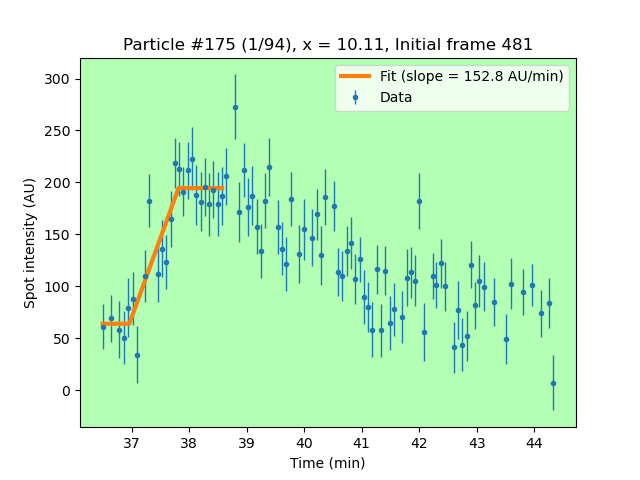

In [29]:
if checked_traces_previous:
    # Load the DataFrame from the .pkl file
    print('Load from previous trace checking results, which are shown below.')
    traces_compiled_dataframe_fits_checked = pd.read_pickle(checked_traces_file_path)
    traces_compiled_dataframe_fits_checked_temp = traces_compiled_dataframe_fits_checked.copy()
    check_particle_fit(traces_compiled_dataframe_fits_checked_temp)

else:
    print('Do trace checking for the dataset')
    check_particle_fit(traces_compiled_dataframe_fits)

In [30]:
# Save the checked traces or update the checked traces if any changes are made

if checked_traces_previous:
    # Check if any changes is made to the approval status of the particles
    if all(traces_compiled_dataframe_fits_checked_temp.approval_status == traces_compiled_dataframe_fits_checked.approval_status):
        print('No changes made to the trace checking results')
    else:
        answer = messagebox.askyesno('Question', 'Changes to the checked traces detected. Save the changes?')
        if answer:
            traces_compiled_dataframe_fits_checked_temp.to_pickle(checked_traces_file_path, compression=None)
            print('Checked traces updated')
        else:
            print('No changes made to the trace checking results')

else:
    traces_compiled_dataframe_fits_checked = traces_compiled_dataframe_fits.reset_index()
    traces_compiled_dataframe_fits_checked.to_pickle(checked_traces_file_path, compression=None)
    print('Checked traces saved')

No changes made to the trace checking results


### Sort the traces by which bin they are in

Define a binning function and an average-computing function

In [31]:
# bin_particles: a function that adds a column to the dataframe indicating the bins the particles belong to. Default bin number is equal to num_bins

def bin_particles(input_dataframe, bin_num=num_bins):
    '''
    Add a column to the compiled_dataframe for particles indicating the bins they belong to.

    ARGUMENT
        input_dataframe: the dataframe to be binned.
        bin_num: the number of bins to partition the embryo, default is equal to num_bins

    OUTPUT
        1. A dataframe with a new column indicating the bin index of the particle.
        2. An array of the number of particles in each bin
    '''

    dataframe = input_dataframe.copy()
    
    bin_width = 1/bin_num

    # Create an array to store the bin indices for each trace
    bin_indices = np.zeros(len(dataframe))
    
    # Loop through dataframe and assign each trace to a bin based on mean ap position
    for i in range(len(dataframe)):
        particle = dataframe['particle'][i]
        bin_indices[i] = (
            dataframe.loc[dataframe['particle'] == particle, 'ap']
            .values[0].mean() // bin_width
        )
        
    dataframe['bin'] = bin_indices.astype(int)

    # Calculate the number of traces in each bin
    bin_counts = np.zeros(bin_num)
    for i in range(bin_num):
        bin_counts[i] = np.sum(bin_indices == i)

    return dataframe, bin_counts

#### Old functions (no longer in use)

In [131]:
# # compute_average_fit_rates_for_bins: a function that calculates the average fit rates for each bin

# def compute_average_fit_rates_for_bins(input_approved_binned_dataframe, bin_num=num_bins):
#     '''
#     Calculate the average fit rates for each bin and store particle
#     IDs with rates in each bin.

#     This function should be applied on a checked dataframe, 
#     i.e. a dataframe in which only the approved particles are left.

#     ARGUMENT
#         approved_binned_dataframe: a particle dataframe with a bin column and only the approved particles are left
#         bin_num: the number of bins to partition the embryo, default is equal to num_bins

#     OUTPUT
#         1. A dictionary giving the following details:
#             - The bin index
#             - The number of particles in that bin
#             - The particle IDs in the bin
#             - The fit rate of each particle in the bin
#         2. An array of average fit rates for each bin
#         3. An array of the number of particles in each bin
#     '''

#     # Bin the particles
#     approved_binned_dataframe, bin_counts = bin_particles(input_approved_binned_dataframe)

#     bin_indices = approved_binned_dataframe['bin'].values

#     # Sorting traces by the bin they belong to, and calculate the average of fit slope for each bin
#     mean_fit_rates = np.zeros(bin_num)
#     bin_particles_rates = np.zeros(bin_num, dtype=object)
#     SE_fit_rates = np.zeros(bin_num)
    
#     for i in range(bin_num):
#         # pass bins that has no particles
#         if bin_counts[i] == 0:
#             mean_fit_rates[i] = np.nan
#             continue
#         else:
#             rates = (
#                 60*approved_binned_dataframe.loc[bin_indices == i, 'fit_results'].apply(
#                     lambda x: x[4][3] if x[4] is not None else np.nan).values
#                 )
#             particles = (
#                 approved_binned_dataframe.loc[bin_indices == i, 'particle']
#                 .values
#                 )
            
#             # Store the particle IDs with their rates in each bin for further analysis
#             bin_particles_rates[i] = {
#                 'bin': i,
#                 'bin_counts': bin_counts[i],
#                 'particles': particles,
#                 'rates': rates
#             }
            
#             mean_fit_rates[i] = (np.nanmean(rates))
    
#             # Standard error of the mean
#             SE_fit_rates[i] = np.nanstd(rates) / np.sqrt(len(rates))

    
#     return bin_counts, bin_particles_rates, mean_fit_rates, SE_fit_rates

Sorting traces by the bin they belong to, and calculate the average of fit slope for each bin

In [ ]:
# approved_compiled_dataframe_fits = traces_compiled_dataframe_fits_checked[traces_compiled_dataframe_fits_checked['approval_status'] == 1]

# bin_counts, bin_particles_rates, mean_fit_rates, SE_fit_rates = compute_average_fit_rates_for_bins(approved_compiled_dataframe_fits)

# print(f'bin_counts = {bin_counts}')
# print(f'np.sum(bin_counts) = {np.sum(bin_counts)}')

#### Newer functions

In [32]:
# compute_average_fit_rates_for_bins: a function that calculates the average fit rates for each bin

def compute_average_fit_rates_for_bins(input_dataframe, bin_num=num_bins):
    '''
    Calculate the average fit rates for each bin and store particle
    IDs with rates in each bin.

    ARGUMENT
        input_dataframe: a particle dataframe
        bin_num: the number of bins to partition the embryo, default is equal to num_bins

    OUTPUT
        1. A dictionary giving the following details:
            - The bin index
            - The number of particles in that bin
            - The particle IDs in the bin
            - The fit rate of each particle in the bin
        2. An array of average fit rates for each bin
        3. An array of the number of particles in each bin
    '''

    # Bin the particles
    approved_mask = (input_dataframe['approval_status'] == 1) | (input_dataframe['approval_status'] == 2)
    
    approved_dataframe = input_dataframe[approved_mask].reset_index()
    
    approved_binned_dataframe, bin_counts = bin_particles(approved_dataframe)
    
    bin_indices = approved_binned_dataframe['bin'].values
    
    # Sorting traces by the bin they belong to, and calculate the average of fit slope for each bin
    mean_fit_rates = np.zeros(bin_num)
    bin_particles_rates = np.zeros(bin_num, dtype=object)
    SE_fit_rates = np.zeros(bin_num)
    
    for i in range(bin_num):
        # pass bins that has no particles
        if bin_counts[i] == 0:
            mean_fit_rates[i] = np.nan
            continue
        else:
            bin_i_dataframe = approved_binned_dataframe[bin_indices == i]
            
            rates = (
                60*bin_i_dataframe['fit_results'].apply(
                    lambda x: x[4][3] if x[4] is not None else np.nan).values
                )
    
            modified_mask = (bin_i_dataframe['approval_status'] == 2)
    
            modified_rates = 60*bin_i_dataframe.loc[modified_mask, 'modified_fit_results'].apply(
                    lambda x: x[4][3] if x[4] is not None else np.nan).values
    
            rates[modified_mask] = modified_rates
    
            particles = (
                approved_binned_dataframe.loc[bin_indices == i, 'particle']
                .values
                )
            
            # Store the particle IDs with their rates in each bin for further analysis
            bin_particles_rates[i] = {
                'bin': i,
                'bin_counts': bin_counts[i],
                'particles': particles,
                'rates': rates
            }
            
            mean_fit_rates[i] = (np.nanmean(rates))
    
            # Standard error of the mean
            SE_fit_rates[i] = np.nanstd(rates) / np.sqrt(len(rates))

    
    return bin_counts, bin_particles_rates, mean_fit_rates, SE_fit_rates

Sort traces by the bin they belong to, and calculate the average of fit slope for each bin

In [33]:
bin_counts, bin_particles_rates, mean_fit_rates, SE_fit_rates = compute_average_fit_rates_for_bins(traces_compiled_dataframe_fits_checked)

print(f'bin_counts = {bin_counts}')
print(f'np.sum(bin_counts) = {np.sum(bin_counts)}')

bin_counts = [ 0.  0.  0.  0.  0.  0.  4. 12.  8. 12.  9.  6. 14.  9. 10.  4.  4.  2.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
np.sum(bin_counts) = 94.0


In [34]:
# Prepare the data for plotting

not_nan_1 = ~np.isnan(mean_fit_rates)

bin_indices_1 = np.arange(num_bins)[not_nan_1]
ap_positions_1 = bin_indices_1 * 1/num_bins

bin_slopes_1 = mean_fit_rates[not_nan_1]
bin_slope_errs_1 = SE_fit_rates[not_nan_1]

max_bin_slope_1 = np.max(bin_slopes_1)
ylim_up = 1.5*max_bin_slope_1

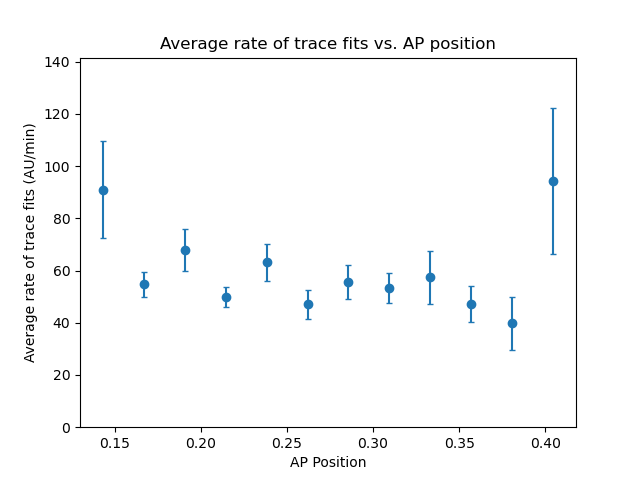

In [35]:
# Plot the average slope of trace fits for each bin number

plt.figure()
plt.errorbar(ap_positions_1, bin_slopes_1, yerr=bin_slope_errs_1, capsize=2, fmt='o')
plt.xlabel('AP Position')
plt.ylabel('Average rate of trace fits (AU/min)')
plt.title('Average rate of trace fits vs. AP position')
plt.ylim(0,ylim_up)
plt.show()

## Scheme 2 (Average & Fit): Taking the Average of All MS2 Traces for Each Bin and then Fit to the Averaged Trace

In [ ]:
time_res_sec = dataset.export_frame_metadata[0]['t_s'][1,0]
time_res_min = time_res_sec/60

In [ ]:
# bin_average_NC14: a function that bins all the traces and takes the average of the traces for each bin

def bin_average_NC14(compiled_dataframe, NC14_start_frame, bin_num=num_bins, shift_to_same_start_frame=True):
    '''
    A function that bins all the traces and takes the average of the traces for each bin.

    ARGUMENTS
        bin_num: number of bins, default value is 42
        shift_to_same_start_frame: if true, shift all NC14 particles so that they start at the same frame.

    OUTPUT
        a list, where each element is a pandas dataframe for one bin containing the average intensity of all 
        the traces in that bin. The average is taken frame-wise.
    '''
       
    # Keep only NC14 particles
    compiled_dataframe_NC14 = compiled_dataframe[compiled_dataframe['frame'].apply(min) >= NC14_start_frame]

    compiled_dataframe_NC14, _ = bin_particles(compiled_dataframe_NC14)

    # Shift all NC14 particles to the same start frame
    if shift_to_same_start_frame:
        for particle in range(len(compiled_dataframe_NC14)):
            try:
                frame_array = compiled_dataframe_NC14['frame'][particle][:]
                first_frame = np.min(frame_array)
                new_frame_array = frame_array - first_frame
                compiled_dataframe_NC14['frame'][particle] = new_frame_array
            except:
                continue

    # sort particles by bins
    binned_particles_NC14 = [None]*bin_num
    for bin in range(bin_num): # for each bin
        mask = compiled_dataframe_NC14["bin"] == bin
        binned_particles_NC14[bin] = compiled_dataframe_NC14[mask]

    
    # A function that sorts intensity data based on bin and frame, and for each bin, calculates the average intensity in each frame
    #----------------------------------------------------------------------------------------------------
    def bin_average_process(binned_particles):
    
        # sort intensity data based on bin and frame
        
        intensity_by_frame = [[] for _ in range(bin_num)]
        
        for bin in range(bin_num):
                
            # find the max and min frame number in a bin
            try:
                max_frame = max(binned_particles[bin]["frame"].apply(np.max))
                min_frame = min(binned_particles[bin]["frame"].apply(np.min))
                
                intensity_by_frame[bin] = pd.DataFrame({'frame': range(min_frame,max_frame), 
                                     'intensity': [[] for _ in range(0,max_frame-min_frame)], 
                                     'average_intensity': [None for _ in range(0,max_frame-min_frame)],
                                    'std_err_intensity': [None for _ in range(0,max_frame-min_frame)]})
                
                bin_particle_num = binned_particles[bin].shape[0]
                
                for frame in range(min_frame, max_frame): # for each frame along the movie
                    FrameIndex = frame - min_frame
                    
                    for particle in range(bin_particle_num): # for each particle in the bin
                        particle_frames = np.array(binned_particles[bin])[particle][1] # extract the frame list of a single particle
                        particle_intensity = np.array(binned_particles[bin])[particle][3] # extract the intensity list of a single particle
    
                        # avoid 0 dimension array that will create undesired results
                        if particle_frames.ndim == 0:
                            particle_frames = np.array([particle_frames])
    
                        if particle_intensity.ndim == 0:
                            particle_intensity = np.array([particle_intensity])
                        
                        for el in range(len(particle_frames)): # for each frame of this particle
                            if particle_frames[el] == frame:
                                # add the intensity value of this particle at this frame to the new data structure
                                intensity_by_frame[bin]['intensity'][FrameIndex].append(particle_intensity[el])
            except:
                continue
    
        
        # for each bin, calculate the average intensity in each frame along with the standard error
        
        for bin in range(bin_num):
            try:
                frame_num = intensity_by_frame[bin].shape[0]
                for frame in range(frame_num):
                    intensity_data = intensity_by_frame[bin]['intensity'][frame]
                    intensity_by_frame[bin]['average_intensity'][frame] = np.mean(intensity_data)
                    intensity_by_frame[bin]['std_err_intensity'][frame] = np.std(intensity_data)/np.sqrt(len(intensity_data))
            except:
                continue
    
        return intensity_by_frame

    #----------------------------------------------------------------------------------------------------

    return bin_average_process(binned_particles_NC14)

In [ ]:
bin_average_intensity_list = bin_average_NC14(compiled_dataframe, NC14_start_frame=nc14_start_frame)

In [ ]:
bin_average_intensity_list[6]

### Define fit functions
Before running the cell below, please run the first cell in Scheme 1. 

In [ ]:
# fit_average_trace: a function that fits the average trace for a single bin

def fit_average_trace(timepoints, MS2, MS2_std, tv_denoised_traces, bin_index):
    # timepoints: the 'frame' column from intensity_by_frame multiplied by time_res_min
    # MS2: the 'average_intensity' column
    # tv_denoised_traces: the 'denoised_average_intensity' column
    # MS2_std: the 'std_erfit_resultsr_intensity' column
    """
    The single-trace version of fit_all_traces.
    """
    fit_result = []

    # Compute the first derivative of TV denoised with respect to time
    dy_dx = first_derivative(timepoints, tv_denoised_traces)

    # Compute the mean of the first derivative over intervals with constant sign
    mean_dy_dx, change_indices = mean_sign_intervals(dy_dx)

    # Keep datapoints from before first sign change
    try:
        timepoints = timepoints[:change_indices[0]]
        MS2 = MS2[:change_indices[0]]
        MS2_std = MS2_std[:change_indices[0]]

        # Interpolate the timepoints
        t_interp = np.linspace(min(timepoints), max(timepoints), 1000)
    except:
        print(f"Failed to find derivative sign change for average trace {bin_index+1}")


    # Compute the fit values
    try:
        basal, t_on, t_dwell, rate, CI = fit_half_cycle(MS2, timepoints, t_interp, MS2_std)

        fit_result = [timepoints,t_interp, MS2, make_half_cycle(basal, t_on, t_dwell, rate, t_interp),
                            [basal, t_on, t_dwell, rate, CI]]
    except Exception as e: 
        print(f"Failed to fit average trace {bin_index+1}: {e}")
        fit_result = [timepoints,t_interp, MS2, None, None]

    return fit_result

In [ ]:
# fit_bin_averages: a function that fits to the average intensity plot for each bin and outputs the slopes of the fits

def fit_bin_averages(bin_average_intensity_list, time_res_min=time_res_min):

    bin_num = len(bin_average_intensity_list)

    fit_results = [None]*bin_num
    fit_slopes = [np.nan]*bin_num

    for bin in range(bin_num):
        try:
            bin_average_intensity = bin_average_intensity_list[bin]
    
            bin_average_intensity_denoised = denoise_bin_average_intensity(bin_average_intensity)

            # Prepare the lists/arrays needed for the fit
            first_frame = bin_average_intensity_denoised['frame'][0]
            x = (bin_average_intensity_denoised['frame'].values - first_frame) * time_res_min
            y = bin_average_intensity_denoised['average_intensity'].values
            y_err = bin_average_intensity_denoised['std_err_intensity'].values
            y_denoised = bin_average_intensity_denoised['denoised_average_intensity'].values

            # Generate the fit
            fit_result = fit_average_trace(x, y, y_err, y_denoised, bin)

            # Store the fit result and the fit slope
            fit_results[bin] = fit_result
            
            try:
                # Store the fit slope
                timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
                fit_slopes[bin] = rate
            except:
                pass

        except:
            continue

    return fit_results, np.array(fit_slopes)


# A function that denoise the dataframes in bin_average_intensity_list, used in the function fit_bin_average

def denoise_bin_average_intensity(bin_average_intensity):

    bin_average_intensity_denoised = bin_average_intensity.copy()
    
    try:
        bin_average_intensity_denoised = bin_average_intensity_denoised.dropna(subset=['average_intensity']) # remove all nan

        # denoise
        before_denoise = np.array(list(bin_average_intensity_denoised['average_intensity']))
        after_denoise = denoise_tv_chambolle(before_denoise, weight=1080, max_num_iter=500)
        
        bin_average_intensity_denoised['denoised_average_intensity'] = after_denoise
        
    except:
        pass
            
    return bin_average_intensity_denoised

In [ ]:
fit_results, fit_slopes = fit_bin_averages(bin_average_intensity_list)

#### Test cells for bin 7 (as there was no fit generated for this bin)

In [ ]:
bin_average_intensity = bin_average_intensity_list[6]

bin_average_intensity_denoised = denoise_bin_average_intensity(bin_average_intensity)

# Prepare the lists/arrays needed for the fit
first_frame = bin_average_intensity_denoised['frame'][0]
x = (bin_average_intensity_denoised['frame'].values - first_frame) * time_res_min
y = bin_average_intensity_denoised['average_intensity'].values
y_err = bin_average_intensity_denoised['std_err_intensity'].values
y_denoised = bin_average_intensity_denoised['denoised_average_intensity'].values

In [ ]:
up = 2
low = 0

mask = (x >= low) & (x <= up)

new_x = x[mask]
new_y = y[mask]
new_yerr = y_err[mask]
plt.figure()
plt.scatter(x, y)
plt.scatter(new_x, new_y)

In [ ]:
x_interp = np.linspace(min(new_x), max(new_x), 1000)

fit_result_bin7 = fit_half_cycle(new_y, new_x, x_interp, new_yerr)

half_cycle_fit_bin7 = make_half_cycle(*fit_result_bin7[:-1], x_interp)

In [ ]:
plt.figure()
plt.errorbar(x, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')
plt.plot(x_interp, half_cycle_fit_bin7, label=f'Fit (slope = {round(fit_result_bin7[3],2)} AU/min)', linewidth=3)
plt.title(f'Bin #7/{num_bins-1}')
plt.xlabel("Time (min)")
plt.ylabel("Spot intensity (AU)")
plt.legend()

### Check the fit to each bin

In [ ]:
# check_bin_fit: a function that checks the fit for each bin

def check_bin_fit(bin_average_intensity_list, fit_results, time_res_min=time_res_min, show_denoised_plot=False, show_fit=True):
    '''
    Check the fit of each particle. All particles are approved by default.

    Note that the bin index shown in the title and the total bin number start from 0, 
    i.e. if it's 2/10 it means it's actually the third bin out of 11 bins.
    '''

    fig, ax = plt.subplots()
    
    bin_index = 0
    bin_num =len(bin_average_intensity_list) 

    # move to the first unchecked particle--------------------------------------
    # first_flag = False
    # while not first_flag:
    #     particle_data = binned_particles_fitted[particle_index:particle_index+1]
    #     status = particle_data['approval_status'].values[0]
    #     if status == 0:
    #         first_flag = True
    #     else:
    #         if particle_index < particle_num:
    #             particle_index += 1
    #         elif particle_index == particle_num:
    #             warn('No particle has been left unchecked')
    #             break
    #---------------------------------------------------------------------------
    # import matplotlib
    # plt.close('all')
    
    def update_plot(bin_index):
        ax.clear()
        try:
            bin_average_intensity = bin_average_intensity_list[bin_index] # select the particle

            bin_average_intensity_denoised = denoise_bin_average_intensity(bin_average_intensity)
            
            x = bin_average_intensity_denoised['frame'].values * time_res_min
            y = bin_average_intensity_denoised['average_intensity'].values
            y_err = bin_average_intensity_denoised['std_err_intensity'].values
            y_denoised = bin_average_intensity_denoised['denoised_average_intensity'].values
    
            # plot the particle trace with error bar along with the denoised trace
            ax.errorbar(x, y, yerr=y_err, fmt=".", elinewidth=1, label='Data')

            if show_denoised_plot:
                ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the half cycle fit
            try:
                fit_result = fit_results[bin_index]
                timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
                if show_fit:
                    ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)} AU/min)', linewidth=3)
    
                # ax.plot(t_interp, make_half_cycle(basal, t_on, t_dwell, rate, t_interp), label=f"Fit (slope = {round(rate, 2)})", linewidth=3, color='orange')
            except:
                pass
    
            # status = particle_data['approval_status'].values[0]
    
            # if status == 1:
            #     ax.set_facecolor((0.7, 1, 0.7)) # approve
            # elif status == -1:
            #     ax.set_facecolor((1, 0.7, 0.7)) # reject color
            # elif status == 0:
            #     ax.set_facecolor((1, 1, 1))
            # elif status == 2:
            #     ax.set_facecolor((1, 1, 0.7))
                
            
            ax.set_title(f'Bin #{bin_index+1}/{bin_num-1}')
            ax.set_xlabel("Time (min)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()

        except Exception as e:
            print(f"Error processing bin {bin_index}: {e}")

        fig.canvas.draw()

    def on_key(event):
        nonlocal bin_index
        if event.key == 'left':
            bin_index = max(0, bin_index - 1)
        elif event.key == 'right':
            bin_index = min(len(bin_average_intensity_list) - 1, bin_index + 1)
        # elif event.key == 'a':
        #     bin_average_intensity_list.at[bin_index, 'approval_status'] = 1
        # elif event.key == 'r':
        #     bin_average_intensity_list.at[bin_index, 'approval_status'] = -1
        # elif event.key == 'c':
        #     bin_average_intensity_list.at[bin_index, 'approval_status'] = 0
        # elif event.key == 'p':
        #     bin_average_intensity_list.at[bin_index, 'approval_status'] = 2
        update_plot(bin_index)

    update_plot(bin_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

In [ ]:
check_bin_fit(bin_average_intensity_list, fit_results, show_denoised_plot=False, show_fit=True)

### Plot slope vs. AP position

In [ ]:
# Prepare the data to be plotted

not_nan_2 = ~np.isnan(fit_slopes)

bin_indices_2 = np.arange(num_bins)[not_nan_2]
bin_slopes_2 = fit_slopes[not_nan_2]

# extract the widths of confidence intervals for the slopes, stored in bin_slope_errs
bin_slope_errs_2 = np.zeros((num_bins, 2))
for bin in range(num_bins):
    try:
        bin_slope_err = fit_results[bin][-1][-1][-1]
        bin_slope_errs_2[bin] = bin_slope_err
    except:
        pass

# Get the bin slope error by subtracting the bounds of the confidence intervals from the slope value
bin_slope_errs_2 = np.transpose(np.abs(bin_slope_errs_2[not_nan_2] - bin_slopes_2[:, np.newaxis]))

In [ ]:
# Plot the bins with data

# Adjust the range of the bins if necessary. Default is start to end
start = 0
end = len(bin_slopes_2)

ap_positions_2 = bin_indices_2 * 1/num_bins

plt.figure()
plt.errorbar(ap_positions_2[start:end], bin_slopes_2[start:end], yerr=bin_slope_errs_2[:,start:end], capsize=2, fmt='o')
plt.xlabel('AP position')
plt.ylabel('Fit rate of average trace (AU/min)')
plt.title('Fit rate of average trace vs. AP position (with shifting)')
plt.ylim(0, ylim_up)
plt.show()

## Scheme 2 Alternative: Pour all the data points in a bin on a plot and fit a slope to it

In [36]:
# Take only NC14 data
dataframe_nc14 = compiled_dataframe[compiled_dataframe['frame'].apply(min) >= nc14_start_frame]

In [37]:
# Generate a list of dataframes called binned_particles_nc14, each dataframe containing all particles in a bin.
binned_dataframe_nc14, _ = bin_particles(dataframe_nc14)

binned_particles_nc14 = [None]*num_bins
for bin in range(num_bins):
    binned_particles_nc14[bin] = binned_dataframe_nc14[binned_dataframe_nc14['bin'] == bin]

In [113]:
binned_particles_nc14[0]

0

In [38]:
# fit_average_trace: a function that fits the average trace for a single bin

def fit_average_trace(timepoints, MS2, MS2_std, tv_denoised_traces, bin_index):
    # timepoints: the 'frame' column from intensity_by_frame multiplied by time_res_min
    # MS2: the 'average_intensity' column
    # tv_denoised_traces: the 'denoised_average_intensity' column
    # MS2_std: the 'std_erfit_resultsr_intensity' column
    """
    The single-trace version of fit_all_traces.
    """
    fit_result = []

    # Compute the first derivative of TV denoised with respect to time
    dy_dx = first_derivative(timepoints, tv_denoised_traces)

    # Compute the mean of the first derivative over intervals with constant sign
    mean_dy_dx, change_indices = mean_sign_intervals(dy_dx)

    # Keep datapoints from before first sign change
    try:
        timepoints = timepoints[:change_indices[0]]
        MS2 = MS2[:change_indices[0]]
        MS2_std = MS2_std[:change_indices[0]]

        # Interpolate the timepoints
        t_interp = np.linspace(min(timepoints), max(timepoints), 1000)
    except:
        print(f"Failed to find derivative sign change for average trace {bin_index+1}")


    # Compute the fit values
    try:
        basal, t_on, t_dwell, rate, CI = fit_half_cycle(MS2, timepoints, t_interp, MS2_std)

        fit_result = [timepoints,t_interp, MS2, make_half_cycle(basal, t_on, t_dwell, rate, t_interp),
                            [basal, t_on, t_dwell, rate, CI]]
    except Exception as e: 
        print(f"Failed to fit average trace {bin_index+1}: {e}")
        fit_result = [timepoints,t_interp, MS2, None, None]

    return fit_result

In [39]:
# bin_average_over_time_bins: a function taking the average of MS2 signals for each time bin along the time axis for an AP bin

def bin_average_over_time_bins(bin_dataframe, time_bin_width=dataset.export_frame_metadata[0]['t_s'][1,0], shift_traces_to_same_start_time=True):

    '''
    This function should be applied on a dataframe of particles for a particular bin.
    What this function does:
    1. Split the time axis into time bins
    2. Average all MS2 signals in each time bin

    ARGUMENT
        bin_dataframe: a pandas dataframe for all the particles in an AP bin
        time_bin_width: float, the width of the time bin, default is the frame duration of the dataset
        shift_traces_to_same_start_time: bool, if true, shift the time array for each particle to start at 0.

    OUTPUT
        1. bin_centers: an array of the time bin centers
        2. bin_means: an array of the mean MS2 signal in each time bin
        3. bin_stds: an array of the standard deviation for the MS2 signals in each time bin
    '''

    # extract the time column
    t_s = bin_dataframe['t_s'].values
    if shift_traces_to_same_start_time:
        t_s_shifted = [None]*len(t_s)
        for i in range(len(t_s)):
            t_first = t_s[i][0]
            shifted_t_s = t_s[i] - t_first
            t_s_shifted[i] = shifted_t_s
        t_s = t_s_shifted

    # extract the intensity column
    intensity = bin_dataframe['intensity_from_neighborhood'].values
    # intensity_err = bin_dataframe['intensity_std_error_from_neighborhood'].values

    # Take averages of all the intensity values over time bins:    
    # 1. Flatten t_s and intensity into single arrays
    t_s_flat = np.concatenate(t_s)
    intensity_flat = np.concatenate(intensity)
    
    # 2. Define time bin edges with specified width
    x_min, x_max = min(t_s_flat), max(t_s_flat)
    time_bins = np.arange(x_min, x_max + time_bin_width, time_bin_width)
    
    # 3. Digitize t_s_flat into time bins
    time_bin_indices = np.digitize(t_s_flat, time_bins)
    
    # 4. Compute the average and standard deviation for the intensity values in each time bin
    time_bin_means = np.array([intensity_flat[time_bin_indices == i].mean() for i in range(1, len(time_bins))])

    time_bin_stddevs = np.array([intensity_flat[time_bin_indices == i].std() for i in range(1, len(time_bins))])

    time_bin_stderrs = np.array([intensity_flat[time_bin_indices == i].std()
                                 /np.sqrt(len(intensity_flat[time_bin_indices == i])) 
                                 for i in range(1, len(time_bins))])
    
    # 5. Get the time bin centers for plotting
    time_bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

    # 6. Drop the entries with nan means
    nan_indices = np.isnan(time_bin_means)

    time_bin_centers = time_bin_centers[~nan_indices]/60
    time_bin_means = time_bin_means[~nan_indices]
    time_bin_stddevs = time_bin_stddevs[~nan_indices]
    time_bin_stderrs = time_bin_stderrs[~nan_indices]

    return np.array([time_bin_centers, time_bin_means, time_bin_stddevs, time_bin_stderrs])

In [57]:
# Store the bin averages for all AP bins in a pandas dataframe

bin_average_fit_dataframe = pd.DataFrame({'time_bin_centers':[None]*num_bins, 
                                          'time_bin_means':[None]*num_bins, 
                                          'time_bin_stddevs':[None]*num_bins, 
                                          'time_bin_stderrs':[None]*num_bins, 
                                          'denoised_time_bin_means':[None]*num_bins,
                                          'bin_fit_result':[None]*num_bins, 
                                          'bin_fit_slope':[np.nan for i in range(num_bins)],
                                          'bin_fit_result_modified':[None]*num_bins, 
                                          'bin_fit_slope_modified':[np.nan for i in range(num_bins)],
                                          'approval_status':[0]*num_bins})

for bin in range(num_bins):
    try:
        [time_bin_centers, time_bin_means, time_bin_stddevs, time_bin_stderrs] = bin_average_over_time_bins(binned_particles_nc14[bin])
        bin_average_fit_dataframe['time_bin_centers'][bin] = time_bin_centers
        bin_average_fit_dataframe['time_bin_means'][bin] = time_bin_means
        bin_average_fit_dataframe['time_bin_stddevs'][bin] = time_bin_stddevs
        bin_average_fit_dataframe['time_bin_stderrs'][bin] = time_bin_stderrs

        denoised_time_bin_means = denoise_tv_chambolle(time_bin_means, weight=1080, max_num_iter=500)
        bin_average_fit_dataframe['denoised_time_bin_means'][bin] = denoised_time_bin_means

        try:
            bin_fit_result = fit_average_trace(time_bin_centers, time_bin_means, time_bin_stderrs, denoised_time_bin_means, bin)
            bin_average_fit_dataframe['bin_fit_result'][bin] = bin_fit_result
            bin_average_fit_dataframe['bin_fit_slope'][bin] = bin_fit_result[4][3]
        except:
            bin_average_fit_dataframe['approval_status'][bin] = -1
    except:
        bin_average_fit_dataframe['approval_status'][bin] = -1

/tmp/ipykernel_2375623/3600921885.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_average_fit_dataframe['approval_status'][bin] = -1
/tmp/ipykernel_2375623/3600921885.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_average_fit_dataframe['approval_status'][bin] = -1
/tmp/ipykernel_2375623/3600921885.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_average_fit_dataframe['approval_status'][bin] = -1
/tmp/ipykerne

Failed to fit average trace 19: Residuals are not finite in the initial point.
Failed to fit average trace 20: Each lower bound must be strictly less than each upper bound.
Failed to fit average trace 21: Each lower bound must be strictly less than each upper bound.
Failed to fit average trace 22: Each lower bound must be strictly less than each upper bound.
Failed to find derivative sign change for average trace 23
Failed to fit average trace 23: local variable 't_interp' referenced before assignment


/tmp/ipykernel_2375623/3600921885.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_average_fit_dataframe['bin_fit_result'][bin] = bin_fit_result
/tmp/ipykernel_2375623/3600921885.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_average_fit_dataframe['bin_fit_slope'][bin] = bin_fit_result[4][3]
/tmp/ipykernel_2375623/1089245754.py:49: RuntimeWarning: Mean of empty slice.
  time_bin_means = np.array([intensity_flat[time_bin_indices == i].mean() for i in range(1, len(time_bins))])
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

In [106]:
bin_average_fit_dataframe

,time_bin_centers,time_bin_means,time_bin_stddevs,time_bin_stderrs,denoised_time_bin_means,bin_fit_result,bin_fit_slope,bin_fit_result_modified,bin_fit_slope_modified,approval_status
0,None,None,None,None,None,None,NaN,None,NaN,-1
1,None,None,None,None,None,None,NaN,None,NaN,-1
2,None,None,None,None,None,None,NaN,None,NaN,-1
3,None,None,None,None,None,None,NaN,None,NaN,-1
4,None,None,None,None,None,None,NaN,None,NaN,-1
5,None,None,None,None,None,None,NaN,None,NaN,-1
6,"[0.037116654713948566, 0.1113499641418457, 0.1...","[77.77398044905473, 84.65395397534031, 84.3782...","[24.49793505218771, 31.666523374538322, 22.810...","[10.00124010495038, 15.833261687269161, 11.405...","[114.8619050568798, 115.10015230773826, 115.58...","[[0.037116654713948566, 0.1113499641418457, 0....",76.884109,None,NaN,0
7,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.96782156556377, 63.95788971831487, 69.5448...","[27.712734332382936, 32.07727107243704, 40.969...","[6.531954123883075, 9.671661131435895, 13.6565...","[87.8323838114404, 88.07514234200306, 88.56935...","[[0.037116654713948566, 0.1113499641418457, 0....",47.905291,None,NaN,0
8,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.37488487243616, 70.37409666753474, 75.7296...","[25.743319644090516, 28.96989067808039, 18.009...","[5.61765290040421, 10.242403074351795, 6.00302...","[92.2519298819578, 92.41141194101532, 92.73584...","[[0.037116654713948566, 0.1113499641418457, 0....",49.575563,None,NaN,0
9,"[0.037116654713948566, 0.1113499641418457, 0.1...","[53.78366013348968, 84.11950096304001, 61.4647...","[21.210677937227143, 18.818167860510084, 18.21...","[4.522131730604968, 7.11259889839687, 6.440398...","[87.38859721476487, 87.60747455794981, 88.0444...","[[0.037116654713948566, 0.1113499641418457, 0....",43.246241,None,NaN,0


In [41]:
# # The check_bin_average_fit using the fit_half_cycle regime for modified fit
# # check_bin_average_fit: a function that allows for checking the bin averages for each bin

# def check_bin_average_fit(bin_average_fit_dataframe, show_denoised_plot=False, show_fit=True, show_std_dev=True, show_std_err=True):
#     '''binned_dataframe_nc14, _ = bin_particles(dataframe_nc14)
#     Check the fit for each bin average.

#     Note that the bin index starts from 1, while the pandas dataframe starts from 0.

#     ARGUMENT
#         bin_average_fit_dataframe: a pandas dataframe containing the bin average fit data.
#         show_denoised_plot: show the denoised trace of the data points, default is False.
#         show_fit: show the half cycle fit for the data points, default is True.
#         show_std_dev: show the standard deviation for each data point.
#         show_std_err: show the standard error for each data point.

#     KEY INPUTS
#         left (<-): move to previous bin
#         right (->): move to next bin
#         a: accept fit for this bin (plot turns green)
#         r: reject fit for this bin (plot turns red)
#         c: clear approval status (plot returns white)
#         f: redo the fit based on data within a certain x range,
#            which is determined by clicking twice on the plot
#            (plot turns yellow)
#     '''

#     fig, ax = plt.subplots()
    
#     bin_index = 0
#     bin_num =len(bin_average_fit_dataframe)
#     click_to_fit = False
    
    
#     def update_plot(bin_index):
#         nonlocal click_to_fit
#         ax.clear()
#         try:
#             x = bin_average_fit_dataframe.loc[bin_index, 'time_bin_centers']
#             y = bin_average_fit_dataframe.loc[bin_index, 'time_bin_means']
#             y_stddev = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stddevs']
#             y_stderr = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stderrs']
#             y_denoised = bin_average_fit_dataframe.loc[bin_index, 'denoised_time_bin_means']
    
#             # plot the particle trace with error bar along with the denoised trace
#             if show_std_dev:
#                 ax.errorbar(x, y, yerr=y_stddev, fmt=".", elinewidth=1, label='Data with std dev', alpha=0.35)
#             if show_std_err:
#                 ax.errorbar(x, y, yerr=y_stderr, fmt=".", elinewidth=1, label='Data with std err')

#             if show_denoised_plot:
#                 ax.plot(x, y_denoised, color='k', label='TV denoised')

#             if click_to_fit:
#                 #click_to_fit = False
                
#                 # Choose the datapoints between two clicks and fit a line to them
#                 clicks = []
                
#                 def onclick(event):
#                     nonlocal click_to_fit
#                     # Capture the click
#                     clicks.append(event.xdata)
#                     if len(clicks) == 2:
#                         # Get the x-coordinates of the two clicks
#                         x_min = min(clicks[0], clicks[1])
#                         x_max = max(clicks[0], clicks[1])
                        
#                         # Select points within the range of x_min and x_max
#                         mask = (x >= x_min) & (x <= x_max)
#                         new_x = x[mask]
#                         new_y = y[mask]
#                         new_yerr = y_stderr[mask]

#                         x_interp = np.linspace(min(new_x), max(new_x), 1000)

#                         # The fit_half_cycle regime------------------------------------------
        
#                         try:
#                             basal, t_on, t_dwell, rate, CI = fit_half_cycle(new_y, new_x, x_interp, new_yerr)
            
#                             bin_fit_result_modified = [new_x, x_interp, new_y, make_half_cycle(basal, t_on, t_dwell, rate, x_interp),
#                                         [basal, t_on, t_dwell, rate, CI]]
        
#                             bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = bin_fit_result_modified
        
#                             bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = rate
    
#                             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 2
                            
#                         except:
#                             pass
#                         #----------------------------------------------------------------------
            
#                         # Disconnect after two clicks
#                         fig.canvas.mpl_disconnect(cid)
#                         click_to_fit = False
#                         update_plot(bin_index)
    
#                 # Connect the click event to the handler
#                 cid = fig.canvas.mpl_connect('button_press_event', onclick)

#             elif 'cid' in locals():
#                 fig.canvas.mpl_disconnect(cid)
    
#             # plot the half cycle fit
#             try:
#                 if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:                    
#                     fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result_modified']
#                     timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
#                     ax.errorbar(timepoints, MS2, fmt=".", elinewidth=1, label='Selected data for new fit')
#                 else:
#                     fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result']
#                     timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
#                 if show_fit:
#                     if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:
#                         ax.plot(t_interp, half_cycle_fit, label=f'Modified fit (slope = {round(rate,2)} AU/min)', linewidth=3)
#                     else:
#                         ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)} AU/min)', linewidth=3)
                    
#             except:
#                 pass
    
#             status = bin_average_fit_dataframe.loc[bin_index, 'approval_status']
    
#             if status == 1:
#                 ax.set_facecolor((0.7, 1, 0.7)) # green
#             elif status == -1:
#                 ax.set_facecolor((1, 0.7, 0.7)) # red
#             elif status == 0:
#                 ax.set_facecolor((1, 1, 1))
#             elif status == 2:
#                 ax.set_facecolor((1, 1, 0.7)) # yellow
                
            
#             ax.set_title(f'Bin {bin_index+1}/{bin_num}')
#             ax.set_xlabel("Time (min)")
#             ax.set_ylabel("Spot intensity (AU)")
#             ax.legend()

#         except Exception as e:
#             print(f"Error processing bin {bin_index}: {e}")

#         fig.canvas.draw()

#     def on_key(event):
#         nonlocal bin_index, click_to_fit
#         if event.key != 'f':
#             click_to_fit = False
        
#         if event.key == 'left':
#             bin_index = max(0, bin_index - 1)
#         elif event.key == 'right':
#             bin_index = min(len(bin_average_fit_dataframe) - 1, bin_index + 1)
#         elif event.key == 'a':
#             # a for accept/approve
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 1
#         elif event.key == 'r':
#             # r for reject
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = -1
#         elif event.key == 'c':
#             # c for clear
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 0
#             bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = None
#             bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = np.nan
#         elif event.key == 'f':
#             # f for fit
#             click_to_fit = not click_to_fit
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = click_to_fit*2
        
#         update_plot(bin_index)

#     update_plot(bin_index)
#     fig.canvas.mpl_connect('key_press_event', on_key)
#     plt.show()

In [42]:
# # The check_bin_average_fit using the linear regime for modified fit
# # check_bin_average_fit: a function that allows for checking the bin averages for each bin

# def check_bin_average_fit(bin_average_fit_dataframe, show_denoised_plot=False, show_fit=True, show_std_dev=True, show_std_err=True):
#     '''
#     Check the fit for each bin average.

#     Note that the bin index starts from 1, while the pandas dataframe starts from 0.

#     ARGUMENT
#         bin_average_fit_dataframe: a pandas dataframe containing the bin average fit data.
#         show_denoised_plot: show the denoised trace of the data points, default is False.
#         show_fit: show the half cycle fit for the data points, default is True.
#         show_std_dev: show the standard deviation for each data point.
#         show_std_err: show the standard error for each data point.

#     KEY INPUTS
#         left (<-): move to previous bin
#         right (->): move to next bin
#         a: accept fit for this bin (plot turns green)
#         r: reject fit for this bin (plot turns red)
#         c: clear approval status (plot returns white)
#         f: redo the fit based on data within a certain x range,
#            which is determined by clicking twice on the plot
#            (plot turns yellow)
#     '''

#     fig, ax = plt.subplots()
    
#     bin_index = 0
#     bin_num =len(bin_average_fit_dataframe)
#     click_to_fit = False
    
    
#     def update_plot(bin_index):
#         nonlocal click_to_fit
#         ax.clear()
#         try:
#             x = bin_average_fit_dataframe.loc[bin_index, 'time_bin_centers']
#             y = bin_average_fit_dataframe.loc[bin_index, 'time_bin_means']
#             y_stddev = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stddevs']
#             y_stderr = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stderrs']
#             y_denoised = bin_average_fit_dataframe.loc[bin_index, 'denoised_time_bin_means']
    
#             # plot the particle trace with error bar along with the denoised trace
#             if show_std_dev:
#                 ax.errorbar(x, y, yerr=y_stddev, fmt=".", elinewidth=1, label='Data with std dev', alpha=0.35)
#             if show_std_err:
#                 ax.errorbar(x, y, yerr=y_stderr, fmt=".", elinewidth=1, label='Data with std err')

#             if show_denoised_plot:
#                 ax.plot(x, y_denoised, color='k', label='TV denoised')

#             if click_to_fit:
#                 #click_to_fit = False
                
#                 # Choose the datapoints between two clicks and fit a line to them
#                 clicks = []
                
#                 def onclick(event):
#                     nonlocal click_to_fit
#                     # Capture the click
#                     clicks.append(event.xdata)
#                     if len(clicks) == 2:
#                         # Get the x-coordinates of the two clicks
#                         x_min = min(clicks[0], clicks[1])
#                         x_max = max(clicks[0], clicks[1])
                        
#                         # Select points within the range of x_min and x_max
#                         mask = (x >= x_min) & (x <= x_max)
#                         new_x = x[mask]
#                         new_y = y[mask]
#                         new_yerr = y_stderr[mask]

#                         x_interp = np.linspace(min(new_x), max(new_x), 1000)

#                         # The linear fit regime----------------------------------------------
#                         try:
#                             f = lambda x, k, b: k*x + b
#                             # Perform linear regression
#                             slope, intercept, r_value, p_value, std_err = stats.linregress(new_x, new_y)
                            
#                             # Calculate standard error for the intercept
#                             n = len(new_x)
#                             new_x_mean = np.mean(new_x)
#                             intercept_std_err = std_err * np.sqrt(np.sum(new_x**2) / (n * np.sum((new_x - new_x_mean)**2)))
                            
#                             # Calculate the confidence intervals
#                             confidence = 0.95
#                             t_value = stats.t.ppf((1 + confidence) / 2., n - 2)  # Two-tailed inverse t distribution
                            
#                             slope_conf_interval = [slope - t_value * std_err, slope + t_value * std_err]
#                             intercept_conf_interval = [intercept - t_value * intercept_std_err, intercept + t_value * intercept_std_err]
                            
#                             bin_fit_result_modified = [new_x, x_interp, new_y, f(x_interp, slope, intercept), 
#                                                        [intercept, np.nan, np.nan, slope, 
#                                                         np.array([intercept_conf_interval, [np.nan, np.nan], 
#                                                                   [np.nan, np.nan], slope_conf_interval])]]

#                             bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = bin_fit_result_modified

#                             bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = slope

#                             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 2
#                         except:
#                             pass
#                         #--------------------------------------------------------------------
            
#                         # Disconnect after two clicks
#                         fig.canvas.mpl_disconnect(cid)
#                         click_to_fit = False
#                         update_plot(bin_index)
    
#                 # Connect the click event to the handler
#                 cid = fig.canvas.mpl_connect('button_press_event', onclick)

#             elif 'cid' in locals():
#                 fig.canvas.mpl_disconnect(cid)
    
#             # plot the half cycle fit
#             try:
#                 if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:                    
#                     fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result_modified']
#                     timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
#                     ax.errorbar(timepoints, MS2, fmt=".", elinewidth=1, label='Selected data for new fit')
#                 else:
#                     fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result']
#                     timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
#                 if show_fit:
#                     if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:
#                         ax.plot(t_interp, half_cycle_fit, label=f'Modified fit (slope = {round(rate,2)} AU/min)', linewidth=3)
#                     else:
#                         ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)} AU/min)', linewidth=3)
                    
#             except:
#                 pass
    
#             status = bin_average_fit_dataframe.loc[bin_index, 'approval_status']
    
#             if status == 1:
#                 ax.set_facecolor((0.7, 1, 0.7)) # green
#             elif status == -1:
#                 ax.set_facecolor((1, 0.7, 0.7)) # red
#             elif status == 0:
#                 ax.set_facecolor((1, 1, 1))
#             elif status == 2:
#                 ax.set_facecolor((1, 1, 0.7)) # yellow
                
            
#             ax.set_title(f'Bin {bin_index+1}/{bin_num}')
#             ax.set_xlabel("Time (min)")
#             ax.set_ylabel("Spot intensity (AU)")
#             ax.legend()

#         except Exception as e:
#             print(f"Error processing bin {bin_index}: {e}")

#         fig.canvas.draw()

#     def on_key(event):
#         nonlocal bin_index, click_to_fit
#         if event.key != 'f':
#             click_to_fit = False
        
#         if event.key == 'left':
#             bin_index = max(0, bin_index - 1)
#         elif event.key == 'right':
#             bin_index = min(len(bin_average_fit_dataframe) - 1, bin_index + 1)
#         elif event.key == 'a':
#             # a for accept/approve
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 1
#         elif event.key == 'r':
#             # r for reject
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = -1
#         elif event.key == 'c':
#             # c for clear
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 0
#             bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = None
#             bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = np.nan
#         elif event.key == 'f':
#             # f for fit
#             click_to_fit = not click_to_fit
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = click_to_fit*2
        
#         update_plot(bin_index)

#     update_plot(bin_index)
#     fig.canvas.mpl_connect('key_press_event', on_key)
#     plt.show()

In [156]:
# # Test check_bin_average_fit (to be modified for MCMC)
# # check_bin_average_fit: a function that allows for checking the bin averages for each bin

# def check_bin_average_fit(bin_average_fit_dataframe, show_denoised_plot=False, show_fit=True, show_std_dev=True, show_std_err=True):
#     '''
#     Check the fit for each bin average.

#     Note that the bin index starts from 1, while the pandas dataframe starts from 0.

#     ARGUMENT
#         bin_average_fit_dataframe: a pandas dataframe containing the bin average fit data.
#         show_denoised_plot: show the denoised trace of the data points, default is False.
#         show_fit: show the half cycle fit for the data points, default is True.
#         show_std_dev: show the standard deviation for each data point.
#         show_std_err: show the standard error for each data point.

#     KEY INPUTS
#         left (<-): move to previous bin
#         right (->): move to next bin
#         a: accept fit for this bin (plot turns green)
#         r: reject fit for this bin (plot turns red)
#         c: clear approval status (plot returns white)
#         f: redo the fit based on data within a certain x range,
#            which is determined by clicking twice on the plot
#            (plot turns yellow)
#     '''

#     fig, ax = plt.subplots()
    
#     bin_index = 0
#     bin_num =len(bin_average_fit_dataframe)
    
    
#     def update_plot(bin_index):
#         ax.clear()
#         try:
#             x = bin_average_fit_dataframe.loc[bin_index, 'time_bin_centers']
#             y = bin_average_fit_dataframe.loc[bin_index, 'time_bin_means']
#             y_stddev = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stddevs']
#             y_stderr = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stderrs']
#             y_denoised = bin_average_fit_dataframe.loc[bin_index, 'denoised_time_bin_means']
    
#             # plot the particle trace with error bar along with the denoised trace
#             if show_std_dev:
#                 ax.errorbar(x, y, yerr=y_stddev, fmt=".", elinewidth=1, label='Data with std dev', alpha=0.35)
#             if show_std_err:
#                 ax.errorbar(x, y, yerr=y_stderr, fmt=".", elinewidth=1, label='Data with std err')

#             if show_denoised_plot:
#                 ax.plot(x, y_denoised, color='k', label='TV denoised')
    
#             # plot the half cycle fit
#             try:
#                 if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:                    
#                     fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result_modified']
#                     timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
#                     ax.errorbar(timepoints, MS2, fmt=".", elinewidth=1, label='Selected data for new fit')
#                 else:
#                     fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result']
#                     timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
    
#                 if show_fit:
#                     if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:
#                         ax.plot(t_interp, half_cycle_fit, label=f'Modified fit (slope = {round(rate,2)} AU/min)', linewidth=3)
#                     else:
#                         ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate,2)} AU/min)', linewidth=3)
                    
#             except:
#                 pass
    
#             status = bin_average_fit_dataframe.loc[bin_index, 'approval_status']
    
#             if status == 1:
#                 ax.set_facecolor((0.7, 1, 0.7)) # green
#             elif status == -1:
#                 ax.set_facecolor((1, 0.7, 0.7)) # red
#             elif status == 0:
#                 ax.set_facecolor((1, 1, 1))
#             elif status == 2:
#                 ax.set_facecolor((1, 1, 0.7)) # yellow
                
            
#             ax.set_title(f'Bin {bin_index+1}/{bin_num}')
#             ax.set_xlabel("Time (min)")
#             ax.set_ylabel("Spot intensity (AU)")
#             ax.legend()

#         except Exception as e:
#             print(f"Error processing bin {bin_index}: {e}")

#         fig.canvas.draw()

#     def on_key(event):
#         nonlocal bin_index, click_to_fit
#         if event.key != 'f':
#             click_to_fit = False
        
#         if event.key == 'left':
#             bin_index = max(0, bin_index - 1)
#         elif event.key == 'right':
#             bin_index = min(len(bin_average_fit_dataframe) - 1, bin_index + 1)
#         elif event.key == 'a':
#             # a for accept/approve
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 1
#         elif event.key == 'r':
#             # r for reject
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = -1
#         elif event.key == 'c':
#             # c for clear
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 0
#             bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = None
#             bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = np.nan
#         elif event.key == 'f':
#             # f for fit
#             click_to_fit = not click_to_fit
#             bin_average_fit_dataframe.at[bin_index, 'approval_status'] = click_to_fit*2
        
#         update_plot(bin_index)

#     update_plot(bin_index)
#     fig.canvas.mpl_connect('key_press_event', on_key)
#     plt.show()

In [102]:
def check_bin_average_fit(bin_average_fit_dataframe, show_denoised_plot=False, show_fit=True, show_std_dev=True, show_std_err=True):
    '''
    Check the fit for each bin average.

    Note that the bin index starts from 1, while the pandas dataframe starts from 0.

    ARGUMENT
        bin_average_fit_dataframe: a pandas dataframe containing the bin average fit data.
        show_denoised_plot: show the denoised trace of the data points, default is False.
        show_fit: show the half cycle fit for the data points, default is True.
        show_std_dev: show the standard deviation for each data point.
        show_std_err: show the standard error for each data point.

    KEY INPUTS
        left (<-): move to previous bin
        right (->): move to next bin
        a: accept fit for this bin (plot turns green)
        r: reject fit for this bin (plot turns red)
        c: clear approval status (plot returns white)
        f: redo the fit based on data within a certain x range,
           which is determined by clicking twice on the plot
           (plot turns yellow)
    '''

    # bin_average_fit_dataframe = self.bin_average_fit_dataframe

    fig, ax = plt.subplots()
    bin_index = 0
    bin_num = len(bin_average_fit_dataframe)
    x = None
    y = None
    y_stddev = None
    y_stderr = None
    y_denoised = None
    
    first_nonempty_bin = 0
    while bin_average_fit_dataframe.loc[first_nonempty_bin, 'time_bin_means'] is None:
        first_nonempty_bin += 1
        if first_nonempty_bin == bin_num:
            break
    
    # move to the first unchecked bin--------------------------------------
    first_flag = False
    while not first_flag:
        bin_data = bin_average_fit_dataframe[bin_index:bin_index + 1]
        status = bin_data['approval_status'].values[0]
        if status == 0:
            first_flag = True
            if not bin_index == 0:
                print(f'Moved to bin {bin_index + 1} out of {bin_num}, the first unchecked bin')
        else:
            if bin_index < bin_num-1:
                bin_index += 1
            elif bin_index == bin_num-1:
                warn('No bin has been left unchecked. Move to the first bin with data')
                bin_index = first_nonempty_bin
                break
    
    # ---------------------------------------------------------------------------
    
    def update_plot(bin_index):
        global x, y, y_stddev, y_stderr, y_denoised
        ax.clear()
        try:
            x = bin_average_fit_dataframe.loc[bin_index, 'time_bin_centers']
            y = bin_average_fit_dataframe.loc[bin_index, 'time_bin_means']
            y_stddev = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stddevs']
            y_stderr = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stderrs']
            y_denoised = bin_average_fit_dataframe.loc[bin_index, 'denoised_time_bin_means']
    
            # plot the bin averaged trace with error bar along with the denoised trace
            if show_std_dev:
                ax.errorbar(x, y, yerr=y_stddev, fmt=".", elinewidth=1, label='Data with std dev', alpha=0.35)
            if show_std_err:
                ax.errorbar(x, y, yerr=y_stderr, fmt=".", elinewidth=1, label='Data with std err')
    
            if show_denoised_plot:
                ax.plot(x, y_denoised, color='k', label='TV denoised')
    
            # plot the half cycle fit
            try:
                if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:
                    fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result_modified']
                    timepoints, t_interp, MS2, linear_fit, [intercept, _, _, rate, CI] = fit_result
                    ax.errorbar(timepoints, MS2, fmt=".", elinewidth=1, label='Selected data for new fit')
    
                    if show_fit:
                        ax.plot(t_interp, linear_fit,
                                label=f'Modified fit (slope = {round(rate, 2)} AU/min)', linewidth=3)
                else:
                    fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result']
                    timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
                    
                    if show_fit:
                        ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate, 2)} AU/min)',
                                linewidth=3)
    
            except:
                pass
    
            status = bin_average_fit_dataframe.loc[bin_index, 'approval_status']
    
            if status == 1:
                ax.set_facecolor((0.7, 1, 0.7))  # green
            elif status == -1:
                ax.set_facecolor((1, 0.7, 0.7))  # red
            elif status == 0:
                ax.set_facecolor((1, 1, 1))
            elif status == 2:
                ax.set_facecolor((1, 1, 0.7))  # yellow
    
            ax.set_title(f'Bin {bin_index + 1}/{bin_num}')
            ax.set_xlabel("Time (min)")
            ax.set_ylabel("Spot intensity (AU)")
            ax.legend()
    
        except Exception as e:
            print(f"Error processing bin {bin_index}: {e}")
    
        fig.canvas.draw()
    
    def on_key(event):
        global bin_index, x, y, y_stddev, y_stderr, y_denoised
        if event.key == 'left':
            bin_index = max(0, bin_index - 1)
        elif event.key == 'right':
            bin_index = min(len(bin_average_fit_dataframe) - 1, bin_index + 1)
        elif event.key == 'a':
            # a for accept/approve
            bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 1
        elif event.key == 'r':
            # r for reject
            bin_average_fit_dataframe.at[bin_index, 'approval_status'] = -1
        elif event.key == 'c':
            # c for clear
            bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 0
            bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = None
            bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = np.nan
        elif event.key == 'f':
            # Fit based on a chosen range
            def get_two_numbers():
                # Create a window
                root = tk.Tk()
                root.withdraw()  # Hide the root window
            
                # Ask for the first number
                num1 = simpledialog.askfloat("Input the range to fit a line", "Enter the left bound of the range:")
                
                # Ask for the second number
                num2 = simpledialog.askfloat("Input the range to fit a line", "Enter the right bound of the range:")
            
                return num1, num2
            
            x_min, x_max = get_two_numbers()
            
            # Select points within the range of x_min and x_max
            mask = (x >= x_min) & (x <= x_max)
            new_x = x[mask]
            new_y = y[mask]
            new_y_stddev = y_stddev[mask]
            new_y_stderr = y_stderr[mask]
    
            x_interp = np.linspace(min(new_x), max(new_x), 1000)
    
            # The linear regime------------------------------------------
            f = lambda k, b, x: k*x + b
            try:
                
                slope, intercept, CI = fit_linear(new_y, new_x, x_interp, new_y_stderr)
    
                slope_conf_interval = CI[0]
                intercept_conf_interval = CI[1]
    
                bin_fit_result_modified = [new_x, x_interp, new_y, f(slope, intercept, x_interp), 
                                                       [intercept, np.nan, np.nan, slope, 
                                                        np.array([intercept_conf_interval, [np.nan, np.nan], 
                                                                  [np.nan, np.nan], slope_conf_interval])]]
    
                bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = bin_fit_result_modified
        
                bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = slope
    
                bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 2
                
            except:      
                pass
    
        update_plot(bin_index)
    
    update_plot(bin_index)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

### Test cells for different fitting methods

[85.0738687888786,
 nan,
 nan,
 28.002463235695732,
 array([[81.98505989, 88.16267768],
        [        nan,         nan],
        [        nan,         nan],
        [19.98163287, 36.0232936 ]])]

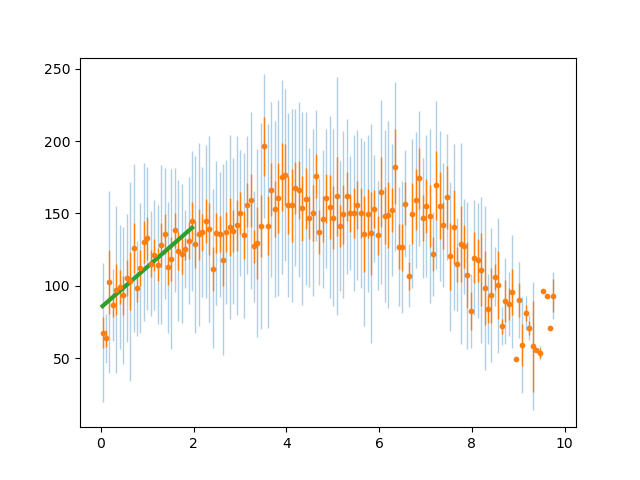

In [149]:
# Linear

bin_index = 11

x = bin_average_fit_dataframe.loc[bin_index, 'time_bin_centers']
y = bin_average_fit_dataframe.loc[bin_index, 'time_bin_means']
y_stddev = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stddevs']
y_stderr = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stderrs']
y_denoised = bin_average_fit_dataframe.loc[bin_index, 'denoised_time_bin_means']

x_min = 0
x_max = 2

# Select points within the range of x_min and x_max
mask = (x >= x_min) & (x <= x_max)
new_x = x[mask]
new_y = y[mask]
new_yerr = y_stderr[mask]

x_interp = np.linspace(min(new_x), max(new_x), 1000)


f = lambda x, k, b: k*x + b

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(new_x, new_y)

# Calculate standard error for the intercept
n = len(new_x)
new_x_mean = np.mean(new_x)
intercept_std_err = std_err * np.sqrt(np.sum(new_x**2) / (n * np.sum((new_x - new_x_mean)**2)))

# Calculate the confidence intervals
confidence = 0.95
t_value = stats.t.ppf((1 + confidence) / 2., n - 2)  # Two-tailed inverse t distribution

slope_conf_interval = [slope - t_value * std_err, slope + t_value * std_err]
intercept_conf_interval = [intercept - t_value * intercept_std_err, intercept + t_value * intercept_std_err]

bin_fit_result_modified = [new_x, x_interp, new_y, f(x_interp, slope, intercept), 
                           [intercept, np.nan, np.nan, slope, 
                            np.array([intercept_conf_interval, [np.nan, np.nan], 
                                      [np.nan, np.nan], slope_conf_interval])]]

plt.figure()
plt.errorbar(x, y, yerr=y_stddev, fmt=".", elinewidth=1, label='Data with std dev', alpha=0.35)
plt.errorbar(x, y, yerr=y_stderr, fmt=".", elinewidth=1, label='Data with std err')
plt.plot(x_interp, bin_fit_result_modified[3], label=f'Modified fit (slope = {round(slope,2)} AU/min)', linewidth=3)
bin_fit_result_modified[-1]

[35.243608476840514,
 73.01107892942386,
 array([[29.52785266, 40.74074608],
        [66.96062653, 78.86166671]])]

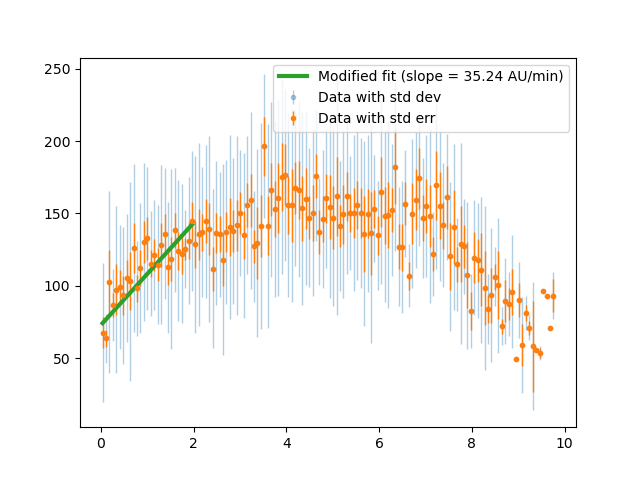

In [150]:
# MCMC

bin_index = 11

x = bin_average_fit_dataframe.loc[bin_index, 'time_bin_centers']
y = bin_average_fit_dataframe.loc[bin_index, 'time_bin_means']
y_stddev = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stddevs']
y_stderr = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stderrs']
y_denoised = bin_average_fit_dataframe.loc[bin_index, 'denoised_time_bin_means']

x_min = 0
x_max = 2

# Select points within the range of x_min and x_max
mask = (x >= x_min) & (x <= x_max)
new_x = x[mask]
new_y = y[mask]
new_yerr = y_stderr[mask]

x_interp = np.linspace(min(new_x), max(new_x), 1000)


f = lambda k, b, x: k*x + b

slope, intercept, CI = fit_linear(new_y, new_x, x_interp, new_yerr)

bin_fit_result_modified = [new_x, x_interp, new_y, f(slope, intercept, x_interp),
            [slope, intercept, CI]]

plt.figure()
plt.errorbar(x, y, yerr=y_stddev, fmt=".", elinewidth=1, label='Data with std dev', alpha=0.35)
plt.errorbar(x, y, yerr=y_stderr, fmt=".", elinewidth=1, label='Data with std err')
plt.plot(x_interp, bin_fit_result_modified[3], label=f'Modified fit (slope = {round(slope,2)} AU/min)', linewidth=3)
plt.legend()
bin_fit_result_modified[-1]

In [151]:
bin_fit_result_modified[-1]

[35.243608476840514,
 73.01107892942386,
 array([[29.52785266, 40.74074608],
        [66.96062653, 78.86166671]])]

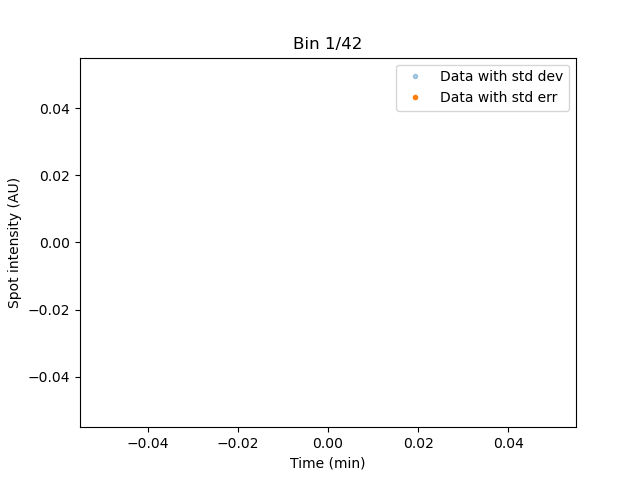

In [157]:
check_bin_average_fit(bin_average_fit_dataframe)

Moved to bin 7 out of 42, the first unchecked bin


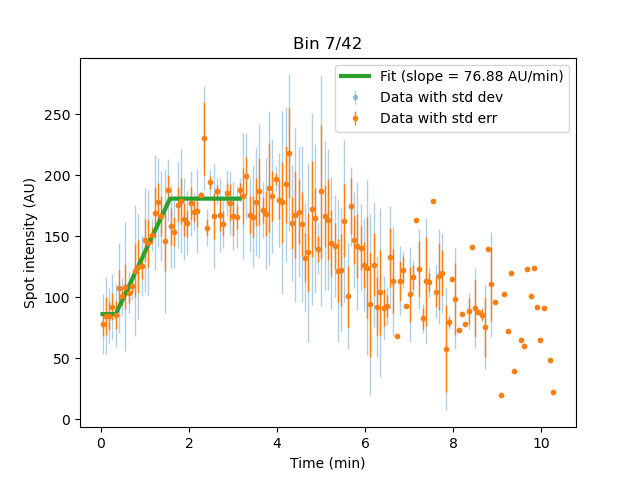

In [98]:
show_denoised_plot=False
show_fit=True
show_std_dev=True
show_std_err=True

# bin_average_fit_dataframe = self.bin_average_fit_dataframe

fig, ax = plt.subplots()
bin_index = 0
bin_num = len(bin_average_fit_dataframe)
x = None
y = None
y_stddev = None
y_stderr = None
y_denoised = None

first_nonempty_bin = 0
while bin_average_fit_dataframe.loc[first_nonempty_bin, 'time_bin_means'] is None:
    first_nonempty_bin += 1
    if first_nonempty_bin == bin_num:
        break

# move to the first unchecked bin--------------------------------------
first_flag = False
while not first_flag:
    bin_data = bin_average_fit_dataframe[bin_index:bin_index + 1]
    status = bin_data['approval_status'].values[0]
    if status == 0:
        first_flag = True
        if not bin_index == 0:
            print(f'Moved to bin {bin_index + 1} out of {bin_num}, the first unchecked bin')
    else:
        if bin_index < bin_num-1:
            bin_index += 1
        elif bin_index == bin_num-1:
            warn('No bin has been left unchecked. Move to the first bin with data')
            bin_index = first_nonempty_bin
            break

# ---------------------------------------------------------------------------

def update_plot(bin_index):
    global x, y, y_stddev, y_stderr, y_denoised
    ax.clear()
    try:
        x = bin_average_fit_dataframe.loc[bin_index, 'time_bin_centers']
        y = bin_average_fit_dataframe.loc[bin_index, 'time_bin_means']
        y_stddev = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stddevs']
        y_stderr = bin_average_fit_dataframe.loc[bin_index, 'time_bin_stderrs']
        y_denoised = bin_average_fit_dataframe.loc[bin_index, 'denoised_time_bin_means']

        # plot the bin averaged trace with error bar along with the denoised trace
        if show_std_dev:
            ax.errorbar(x, y, yerr=y_stddev, fmt=".", elinewidth=1, label='Data with std dev', alpha=0.35)
        if show_std_err:
            ax.errorbar(x, y, yerr=y_stderr, fmt=".", elinewidth=1, label='Data with std err')

        if show_denoised_plot:
            ax.plot(x, y_denoised, color='k', label='TV denoised')

        # plot the half cycle fit
        try:
            if bin_average_fit_dataframe.at[bin_index, 'approval_status'] == 2:
                fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result_modified']
                timepoints, t_interp, MS2, linear_fit, [intercept, _, _, rate, CI] = fit_result
                ax.errorbar(timepoints, MS2, fmt=".", elinewidth=1, label='Selected data for new fit')

                if show_fit:
                    ax.plot(t_interp, linear_fit,
                            label=f'Modified fit (slope = {round(rate, 2)} AU/min)', linewidth=3)
            else:
                fit_result = bin_average_fit_dataframe.loc[bin_index, 'bin_fit_result']
                timepoints, t_interp, MS2, half_cycle_fit, [basal, t_on, t_dwell, rate, CI] = fit_result
                
                if show_fit:
                    ax.plot(t_interp, half_cycle_fit, label=f'Fit (slope = {round(rate, 2)} AU/min)',
                            linewidth=3)

        except:
            pass

        status = bin_average_fit_dataframe.loc[bin_index, 'approval_status']

        if status == 1:
            ax.set_facecolor((0.7, 1, 0.7))  # green
        elif status == -1:
            ax.set_facecolor((1, 0.7, 0.7))  # red
        elif status == 0:
            ax.set_facecolor((1, 1, 1))
        elif status == 2:
            ax.set_facecolor((1, 1, 0.7))  # yellow

        ax.set_title(f'Bin {bin_index + 1}/{bin_num}')
        ax.set_xlabel("Time (min)")
        ax.set_ylabel("Spot intensity (AU)")
        ax.legend()

    except Exception as e:
        print(f"Error processing bin {bin_index}: {e}")

    fig.canvas.draw()

def on_key(event):
    global bin_index, x, y, y_stddev, y_stderr, y_denoised
    if event.key == 'left':
        bin_index = max(0, bin_index - 1)
    elif event.key == 'right':
        bin_index = min(len(bin_average_fit_dataframe) - 1, bin_index + 1)
    elif event.key == 'a':
        # a for accept/approve
        bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 1
    elif event.key == 'r':
        # r for reject
        bin_average_fit_dataframe.at[bin_index, 'approval_status'] = -1
    elif event.key == 'c':
        # c for clear
        bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 0
        bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = None
        bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = np.nan
    elif event.key == 'f':
        # Fit based on a chosen range
        def get_two_numbers():
            # Create a window
            root = tk.Tk()
            root.withdraw()  # Hide the root window
        
            # Ask for the first number
            num1 = simpledialog.askfloat("Input the range to fit a line", "Enter the left bound of the range:")
            
            # Ask for the second number
            num2 = simpledialog.askfloat("Input the range to fit a line", "Enter the right bound of the range:")
        
            return num1, num2
        
        x_min, x_max = get_two_numbers()
        
        # Select points within the range of x_min and x_max
        mask = (x >= x_min) & (x <= x_max)
        new_x = x[mask]
        new_y = y[mask]
        new_y_stddev = y_stddev[mask]
        new_y_stderr = y_stderr[mask]

        x_interp = np.linspace(min(new_x), max(new_x), 1000)

        # The linear regime------------------------------------------
        f = lambda k, b, x: k*x + b
        try:
            
            slope, intercept, CI = fit_linear(new_y, new_x, x_interp, new_y_stderr)
    
            slope_conf_interval = CI[0]
            intercept_conf_interval = CI[1]
    
            bin_fit_result_modified = [new_x, x_interp, new_y, f(slope, intercept, x_interp), 
                                                   [intercept, np.nan, np.nan, slope, 
                                                    np.array([intercept_conf_interval, [np.nan, np.nan], 
                                                              [np.nan, np.nan], slope_conf_interval])]]
    
            bin_average_fit_dataframe.at[bin_index, 'bin_fit_result_modified'] = bin_fit_result_modified
    
            bin_average_fit_dataframe.at[bin_index, 'bin_fit_slope_modified'] = slope
    
            bin_average_fit_dataframe.at[bin_index, 'approval_status'] = 2
            
        except:      
            pass

    update_plot(bin_index)

update_plot(bin_index)
fig.canvas.mpl_connect('key_press_event', on_key)
plt.show()

In [101]:
bin_average_fit_dataframe

,time_bin_centers,time_bin_means,time_bin_stddevs,time_bin_stderrs,denoised_time_bin_means,bin_fit_result,bin_fit_slope,bin_fit_result_modified,bin_fit_slope_modified,approval_status
0,None,None,None,None,None,None,NaN,None,NaN,-1
1,None,None,None,None,None,None,NaN,None,NaN,-1
2,None,None,None,None,None,None,NaN,None,NaN,-1
3,None,None,None,None,None,None,NaN,None,NaN,-1
4,None,None,None,None,None,None,NaN,None,NaN,-1
5,None,None,None,None,None,None,NaN,None,NaN,-1
6,"[0.037116654713948566, 0.1113499641418457, 0.1...","[77.77398044905473, 84.65395397534031, 84.3782...","[24.49793505218771, 31.666523374538322, 22.810...","[10.00124010495038, 15.833261687269161, 11.405...","[114.8619050568798, 115.10015230773826, 115.58...","[[0.037116654713948566, 0.1113499641418457, 0....",76.884109,"[[0.037116654713948566, 0.1113499641418457, 0....",55.046267,2
7,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.96782156556377, 63.95788971831487, 69.5448...","[27.712734332382936, 32.07727107243704, 40.969...","[6.531954123883075, 9.671661131435895, 13.6565...","[87.8323838114404, 88.07514234200306, 88.56935...","[[0.037116654713948566, 0.1113499641418457, 0....",47.905291,None,NaN,0
8,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.37488487243616, 70.37409666753474, 75.7296...","[25.743319644090516, 28.96989067808039, 18.009...","[5.61765290040421, 10.242403074351795, 6.00302...","[92.2519298819578, 92.41141194101532, 92.73584...","[[0.037116654713948566, 0.1113499641418457, 0....",49.575563,None,NaN,0
9,"[0.037116654713948566, 0.1113499641418457, 0.1...","[53.78366013348968, 84.11950096304001, 61.4647...","[21.210677937227143, 18.818167860510084, 18.21...","[4.522131730604968, 7.11259889839687, 6.440398...","[87.38859721476487, 87.60747455794981, 88.0444...","[[0.037116654713948566, 0.1113499641418457, 0....",43.246241,None,NaN,0


### End of Test Cells

Moved to bin 7 out of 42, the first unchecked bin


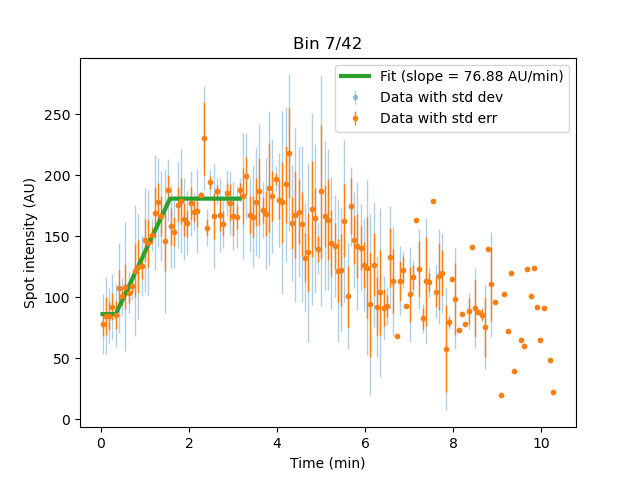

In [103]:
check_bin_average_fit(bin_average_fit_dataframe)

In [104]:
def plot_slope_vs_ap_3(bin_average_fit_dataframe):

    '''
    Plot slope vs. AP position for this scheme.

    ARGUMENT
        bin_average_fit_dataframe

    OUTPUT
        [ap_positions, bin_slopes, bin_slope_errs]
    '''

    # Prepare the quantities needed
    bin_num = len(bin_average_fit_dataframe)
    bin_fit_slopes = bin_average_fit_dataframe['bin_fit_slope'].values
    bin_fit_results = bin_average_fit_dataframe['bin_fit_result'].values

    # Take the bins with definite slope values
    not_nan = ~np.isnan(bin_fit_slopes)
    accept = (bin_average_fit_dataframe['approval_status'] == 1).values
    mask = (not_nan & accept)

    bin_indices = np.arange(bin_num)[mask]
    bin_slopes = bin_fit_slopes[mask]
    
    # extract the widths of confidence intervals for the slopes, stored in bin_slope_errs
    bin_slope_errs = np.zeros((bin_num, 2))
    for bin in range(bin_num):
        try:
            bin_slope_err = bin_fit_results[bin][-1][-1][-1]
            bin_slope_errs[bin] = bin_slope_err
        except:
            pass
    
    # Get the bin slope error by subtracting the bounds of the confidence intervals from the slope value
    bin_slope_errs = np.transpose(np.abs(bin_slope_errs[mask] - bin_slopes[:, np.newaxis]))

    ap_positions = bin_indices * 1/bin_num

    plt.figure()
    plt.errorbar(ap_positions, bin_slopes, yerr=bin_slope_errs, capsize=2, fmt='o')
    plt.xlabel('AP position')
    plt.ylabel('Fit rate of average trace (AU/min)')
    plt.title('Fit rate of average trace vs. AP position (with shifting)')
    plt.show()

    return [ap_positions, bin_slopes, bin_slope_errs]

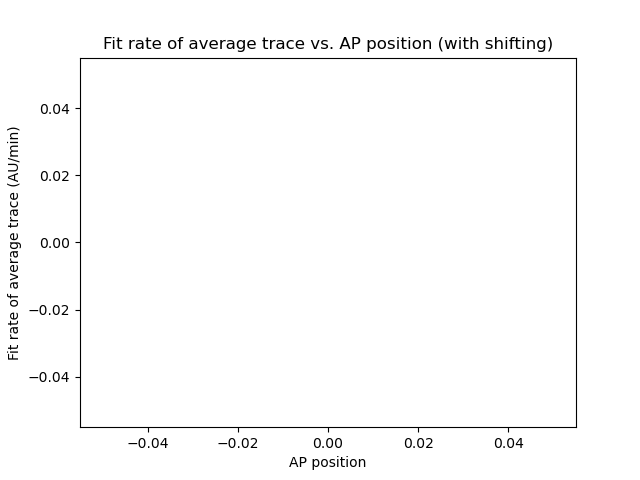

In [105]:
scheme3_plot = plot_slope_vs_ap_3(bin_average_fit_dataframe)

## Overlaying the results from the two schemes

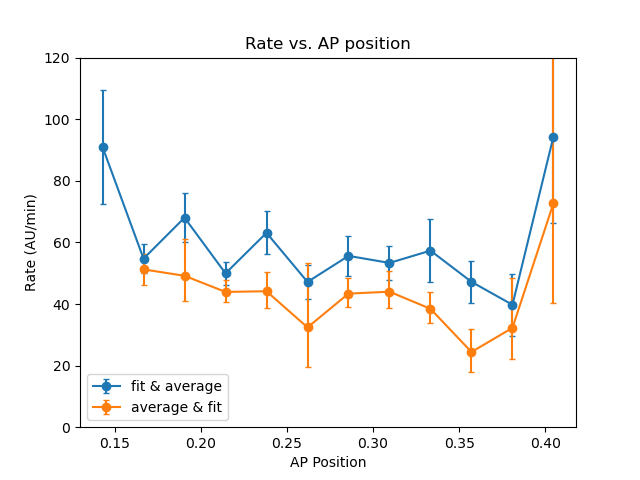

In [49]:
plt.figure()
plt.xlabel('AP Position')
plt.ylabel('Rate (AU/min)')
plt.title('Rate vs. AP position')
plt.ylim(0, 120)

# Scheme 1: Fit & Average
plt.errorbar(ap_positions_1, bin_slopes_1, yerr=bin_slope_errs_1, capsize=2, fmt='o-', label='fit & average')

# Scheme 2: Average & Fit
# Adjust the range of the bins if necessary. Default is start to end
start = 0
end = len(bin_slopes_2)
plt.errorbar(ap_positions_2[start:end], bin_slopes_2[start:end], yerr=bin_slope_errs_2[:,start:end], capsize=2, fmt='o-', label='average & fit')

plt.legend()
plt.show()

#### With bin 7 added

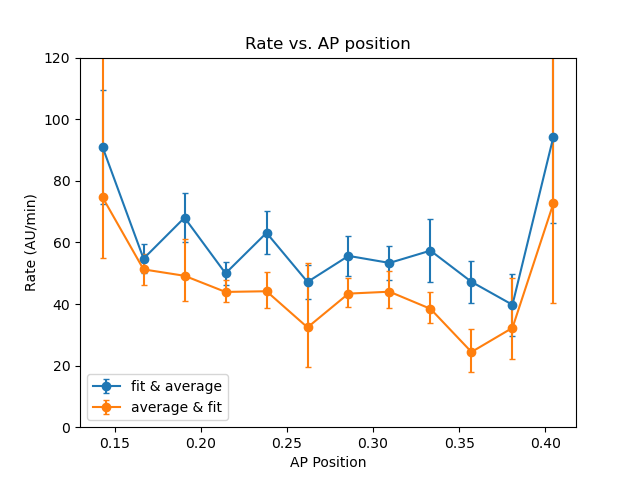

In [50]:
plt.figure()
plt.xlabel('AP Position')
plt.ylabel('Rate (AU/min)')
plt.title('Rate vs. AP position')
plt.ylim(0, 120)

# Scheme 1: Fit & Average
plt.errorbar(ap_positions_1, bin_slopes_1, yerr=bin_slope_errs_1, capsize=2, fmt='o-', label='fit & average')

# Scheme 2: Average & Fit
# Add bin 7 data
ap_positions_2_bin7added = np.insert(ap_positions_2, 0, (7-1)/42)

bin7_slope = fit_result_bin7[3]
bin7_slope_err = np.abs(fit_result_bin7[-1][-1] - bin7_slope).reshape(2,1)
bin_slopes_2_bin7added = np.hstack((bin7_slope, bin_slopes_2))
bin_slope_errs_2_bin7added = np.hstack((bin7_slope_err, bin_slope_errs_2))

# Plot
# Adjust the range of the bins if necessary. Default is start to end
start = 0
end = len(bin_slopes_2_bin7added)
plt.errorbar(ap_positions_2_bin7added[start:end], bin_slopes_2_bin7added[start:end], yerr=bin_slope_errs_2_bin7added[:,start:end], capsize=2, fmt='o-', label='average & fit')

plt.legend()
plt.show()